This is our final version of the CNN+LSTM model with the GTZAN dataset. After adding 3 LSTM layers and stacking the melspec inputs, we have accomplished significant accuracy gains, so for the final model, we decided to focus on improving the fit of learning curves. We changed from L1 to L2=0.02 for kernel regularization, implemented learning rate reduction on plateaus, data augmentation, and even modified some dropout values. As a result, we have further raised our accuracy to 0.77 and significantly improved the fit. Please note that this final model was run again for the purpose of debugging the Dortmund model and so the results of the initial trial were overwritten by those of the most recent trial. Refer to the 1-5 graphs in the supplementary materials section of the paper.

In [1]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

In [3]:
# For reproducibility purposes
np.random.seed(42)

# Read the data

> Helper functions to assist the process to read songs, split then and return an array of spectrograms/melspectrograms

In [4]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
#0.1 of 30sec is 3 sec
#try with 0.05 window

def splitsongs(X, y, window = 0.1, overlap = 0.5):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [5]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=512):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [6]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

        # Convert to "spec" representation
        specs = to_melspectrogram(signals)

        # Save files
        arr_genres.extend(y)
        arr_specs.extend(specs)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [7]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)
    

    return X_train, X_test, y_train, y_test

In [8]:
# Parameters
gtzan_dir = '../data/genres/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0123291  -0.0269165  -0.0670166  ...  0.02819824  0.09997559
  0.15484619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1227417  -0.13146973 -0.26950073 ...  0.01837158  0.02359009
  0.04147339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1829834  0.18634033 0.16748047 ... 0.62887573 0.6312561  0.6210022 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.26190186 -0.17855835 -0.09838867 ...  0.10076904  0.09237671
  0.0397644 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07675171 -0.01437378 -0.03799438 ...  0.20742798  0.21972656
  0.01046753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12734985 -0.09448242  0.06515503 ...  0.17315674  0.02258301
 -0.07601929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04962158 0.07266235 0.087677   ... 0.05377197 0.05215454 0.04577637] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01098633 -0.0027771   0.0012207  ...  0.09228516  0.07202148
  0.05990601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03961182 0.04104614 0.03103638 ... 0.02481079 0.02642822 0.02584839] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19445801 -0.27301025 -0.16564941 ... -0.06280518  0.00976562
  0.01101685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11526489 -0.11297607 -0.1642456  ...  0.12475586  0.1383667
  0.14572144] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04217529  0.0218811   0.05490112 ...  0.16827393  0.17648315
  0.17041016] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00408936  0.00198364 -0.01489258 ...  0.140625    0.16864014
  0.18673706] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00613403  0.00906372  0.01251221 ... -0.11276245 -0.06375122
 -0.00405884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.20599365 0.23449707 0.2522583  ... 0.07409668 0.0881958  0.06982422] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11309814 -0.09802246 -0.08843994 ...  0.12542725  0.12945557
  0.13623047] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.08502197 0.14257812 0.15310669 ... 0.3191223  0.33932495 0.3499756 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00546265 0.01553345 0.02459717 ... 0.12481689 0.12142944 0.11727905] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03488159 -0.0385437  -0.01739502 ...  0.04205322  0.04525757
  0.05502319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01333618 -0.02218628 -0.0480957  ...  0.03503418  0.11129761
  0.10159302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07821655  0.06887817  0.05395508 ... -0.08084106 -0.06671143
 -0.00494385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04840088 -0.01776123  0.06015015 ...  0.0390625   0.10882568
  0.06188965] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03213501  0.03494263  0.04199219 ...  0.1388855   0.07183838
 -0.05801392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08413696  0.12289429  0.10101318 ... -0.12393188  0.00082397
  0.0562439 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01470947 -0.01409912 -0.02099609 ...  0.03317261  0.03845215
  0.0378418 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01080322 -0.00891113 -0.00863647 ...  0.00527954  0.00619507
  0.00891113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03161621  0.03353882  0.04522705 ... -0.02603149 -0.04986572
 -0.06561279] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.09338379 0.04525757 0.01416016 ... 0.00805664 0.06756592 0.09994507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07806396 -0.00167847 -0.00628662 ...  0.11642456  0.12716675
 -0.29418945] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09204102  0.11584473  0.16751099 ... -0.6424866  -0.5336304
 -0.49020386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05050659 -0.03015137 -0.02493286 ... -0.01144409 -0.01089478
 -0.00897217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04714966 -0.04162598 -0.03887939 ... -0.02456665 -0.01766968
 -0.00906372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00698853 -0.00616455 -0.006073   ... -0.02035522 -0.0171814
 -0.00866699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0123291  -0.0118103  -0.01904297 ... -0.13916016 -0.14834595
 -0.15539551] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01937866 0.00585938 0.01708984 ... 0.05435181 0.04049683 0.02908325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1621399  -0.16796875 -0.17089844 ... -0.09091187 -0.08996582
 -0.07888794] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06549072 -0.19958496 -0.17861938 ...  0.08154297  0.09417725
  0.02508545] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06442261 -0.14453125 -0.17504883 ...  0.00256348  0.02062988
 -0.08139038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12280273 -0.17324829 -0.11245728 ...  0.09451294  0.05557251
  0.07580566] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05767822  0.05569458  0.26327515 ...  0.02642822  0.00067139
  0.14703369] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08648682  0.18939209  0.13516235 ... -0.1871643  -0.21124268
 -0.18841553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07843018 -0.06692505 -0.12521362 ... -0.10198975 -0.04251099
  0.05389404] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.25201416 -0.2487793  -0.3331604  ... -0.10571289 -0.00997925
  0.02398682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1133728  0.10333252 0.11206055 ... 0.39593506 0.39941406 0.48257446] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-5.9173584e-02  7.9223633e-02  1.9259644e-01 ... -1.8463135e-02
 -3.5766602e-02  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_f

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.25598145 -0.26696777 -0.23739624 ... -0.24108887 -0.2296753
 -0.21173096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.040802   -0.00125122  0.00360107 ...  0.38250732  0.27059937
  0.2460022 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.20657349 -0.19946289 -0.17999268 ...  0.03509521  0.02459717
  0.01660156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11380005  0.13497925  0.14910889 ... -0.065979   -0.07788086
 -0.09335327] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02661133 -0.14837646 -0.1831665  ...  0.09594727  0.02032471
 -0.03033447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10110474 -0.09817505 -0.08847046 ... -0.07644653 -0.16223145
 -0.17745972] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05010986 -0.09106445 -0.10678101 ...  0.11373901  0.07098389
  0.02972412] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.4352417  -0.43029785 -0.21713257 ... -0.143219   -0.3093567
 -0.38287354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02490234  0.02450562  0.02981567 ... -0.27038574 -0.30566406
 -0.30664062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02194214  0.03826904  0.05712891 ... -0.01480103 -0.01638794
 -0.01876831] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 1.7395020e-03 -9.1552734e-05 -4.1809082e-03 ...  1.0681152e-02
  6.1645508e-03  2.8381348e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02069092 -0.01898193 -0.01269531 ... -0.0100708  -0.01150513
 -0.01290894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03930664  0.01821899 -0.01696777 ...  0.09744263  0.0687561
  0.06799316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08108521 -0.0859375  -0.065979   ... -0.02984619 -0.05130005
 -0.07290649] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08044434  0.07391357  0.08132935 ... -0.06814575 -0.09542847
 -0.10244751] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00909424  0.01104736  0.02261353 ... -0.00653076 -0.01055908
 -0.01281738] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.49206543 -0.32577515 -0.42855835 ... -0.02944946 -0.05697632
 -0.08990479] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.07272339 0.10369873 0.10211182 ... 0.0843811  0.09204102 0.08874512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0083313  -0.01248169 -0.0057373  ... -0.02609253 -0.03173828
 -0.02810669] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09347534 -0.05505371 -0.05197144 ... -0.07012939 -0.12902832
 -0.2119751 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02490234 -0.03805542 -0.02841187 ... -0.15777588 -0.1390686
 -0.12936401] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0062561  0.03488159 0.02310181 ... 0.1421814  0.11297607 0.24798584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00912476  0.01159668  0.01168823 ...  0.00613403  0.05047607
  0.09841919] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.22686768  0.1749878   0.3543396  ... -0.01101685 -0.01159668
 -0.00531006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.7531433   0.7732239   0.77578735 ...  0.16915894  0.07543945
 -0.00875854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.39364624 -0.40594482 -0.40322876 ...  0.00784302  0.01849365
 -0.0078125 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0262146  -0.03353882 -0.02880859 ... -0.25997925 -0.27087402
 -0.32086182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14541626 -0.09417725 -0.04226685 ... -0.05392456  0.11480713
  0.12457275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07907104  0.05557251 -0.00567627 ... -0.00946045 -0.01806641
 -0.0166626 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05770874 -0.13024902 -0.24438477 ... -0.02127075 -0.01422119
 -0.00222778] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02410889  0.02575684  0.03051758 ... -0.0690918  -0.07003784
 -0.07034302] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09249878 -0.09463501 -0.09439087 ... -0.01882935 -0.02035522
 -0.02310181] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07052612 -0.07250977 -0.07565308 ... -0.10983276 -0.11178589
 -0.11282349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02987671  0.02584839  0.02822876 ...  0.18054199 -0.05566406
  0.13052368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00946045 -0.01947021  0.00213623 ... -0.0140686  -0.00793457
 -0.01422119] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.28805542  0.02688599 -0.04794312 ...  0.16210938  0.14715576
  0.1395874 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.33200073  0.32540894  0.32629395 ... -0.06185913 -0.06112671
 -0.06240845] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06817627 -0.06271362 -0.06207275 ... -0.0864563  -0.10275269
 -0.10681152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06408691 -0.06542969 -0.06661987 ...  0.13015747  0.15145874
  0.1586914 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10806274 -0.07833862 -0.0475769  ... -0.12460327 -0.14404297
 -0.12277222] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16427612 -0.16204834 -0.15960693 ... -0.02392578 -0.02932739
 -0.03396606] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1210022  -0.13604736 -0.11730957 ... -0.0222168  -0.02224731
 -0.01824951] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19772339 -0.18829346 -0.14749146 ... -0.19625854 -0.14926147
 -0.1736145 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00363159 -0.01156616 -0.02233887 ...  0.16125488  0.1569519
  0.08190918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.22625732 -0.2654724  -0.1982727  ... -0.1545105  -0.21966553
 -0.2046814 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.2328186   0.26150513  0.24957275 ... -0.0484314  -0.0425415
  0.0249939 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.28048706 -0.27804565 -0.26992798 ...  0.41680908  0.40756226
  0.29196167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01483154  0.00656128 -0.00634766 ...  0.00112915 -0.00558472
 -0.00762939] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02093506 -0.02072144 -0.02487183 ...  0.02954102  0.03234863
  0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02426147 -0.02102661 -0.01358032 ... -0.17532349 -0.25097656
 -0.2746582 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03414917 -0.03057861 -0.04229736 ... -0.00485229 -0.0078125
 -0.00695801] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07504272 -0.10305786 -0.13809204 ...  0.23284912  0.23376465
  0.22653198] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01260376 -0.04602051  0.02859497 ... -0.01754761 -0.01309204
 -0.01812744] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.23300171 0.2579651  0.2637329  ... 0.30691528 0.29916382 0.3256836 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03985596 0.03735352 0.03915405 ... 0.01361084 0.01306152 0.01940918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00305176  0.00137329  0.00415039 ... -0.00091553 -0.00027466
  0.00018311] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00332642 -0.00061035  0.00106812 ...  0.00125122  0.0012207
  0.00112915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-3.9672852e-04 -3.0517578e-05  3.9672852e-04 ... -2.4566650e-01
 -1.7266846e-01 -1.6162109e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11734009 -0.19186401 -0.25558472 ... -0.07949829 -0.11813354
 -0.14627075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.21374512 -0.0708313  -0.08694458 ...  0.08190918  0.22439575
  0.25054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01168823 -0.01483154 -0.01672363 ... -0.019104   -0.01016235
 -0.00668335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02871704  0.01242065 -0.02301025 ... -0.02383423 -0.02914429
 -0.02984619] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00653076 -0.01248169 -0.00692749 ... -0.02365112 -0.01089478
  0.00048828] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02285767  0.00469971  0.02056885 ... -0.03305054 -0.03240967
 -0.0317688 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03860474  0.03338623  0.01821899 ... -0.06448364 -0.05960083
 -0.0524292 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03213501 -0.03234863 -0.0322876  ... -0.01538086 -0.01733398
 -0.01150513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00927734 -0.00985718 -0.00915527 ... -0.00164795 -0.00296021
  0.00256348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0194397  -0.0227356  -0.00830078 ...  0.00094604  0.00369263
  0.0072937 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00650024  0.01004028  0.00973511 ... -0.00732422 -0.00869751
 -0.00665283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.021698   -0.02178955 -0.04074097 ...  0.02313232  0.02337646
  0.0256958 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00601196 -0.00109863 -0.00509644 ...  0.03274536  0.0291748
  0.03723145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02529907 0.0291748  0.02798462 ... 0.23123169 0.25671387 0.24694824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04013062 -0.10617065 -0.14038086 ... -0.00540161 -0.01727295
 -0.01925659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04684448 -0.04266357 -0.05413818 ... -0.13070679 -0.16427612
 -0.16235352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00234985  0.01455688  0.01953125 ...  0.09313965  0.10916138
  0.09628296] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06582642 -0.01123047 -0.009552   ...  0.04165649  0.03250122
  0.05801392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0296936  -0.01150513 -0.02359009 ...  0.08096313  0.08001709
  0.05038452] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.07144165 0.03622437 0.00765991 ... 0.03274536 0.08303833 0.03308105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04281616  0.02072144 -0.00137329 ...  0.2494812   0.21676636
  0.16537476] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00927734 0.02197266 0.03530884 ... 0.02456665 0.02160645 0.01773071] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.13415527 0.15560913 0.19934082 ... 0.02835083 0.02557373 0.01702881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06985474  0.07446289  0.08187866 ... -0.0866394  -0.01528931
  0.0796814 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03320312 -0.03793335 -0.02484131 ... -0.05545044 -0.04006958
  0.06332397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11520386  0.07333374 -0.0246582  ... -0.04934692  0.02694702
  0.08596802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04501343  0.05114746  0.04260254 ... -0.2116394  -0.22195435
 -0.25250244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05615234 -0.06848145 -0.1053772  ...  0.06329346  0.12307739
  0.12179565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2713623  -0.27453613 -0.2725525  ...  0.08395386  0.02514648
 -0.00891113] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1867981  0.17074585 0.09646606 ... 0.03076172 0.05953979 0.04376221] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00134277 -0.00131226 -0.00036621 ...  0.01959229  0.01916504
  0.01928711] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0057373  -0.06484985 -0.10903931 ... -0.06152344 -0.06237793
 -0.06347656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.26660156  0.28424072  0.23913574 ... -0.40499878 -0.3040161
 -0.45092773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05349731 -0.10427856 -0.10140991 ... -0.33859253 -0.36639404
 -0.4154663 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07980347 -0.27038574 -0.38500977 ...  0.31817627  0.28433228
  0.23641968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01077271 -0.02001953 -0.02426147 ...  0.01858521  0.03250122
  0.04174805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00405884 -0.00646973 -0.00823975 ...  0.04586792  0.06124878
  0.06762695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04678345  0.04763794  0.04608154 ... -0.02774048 -0.03213501
 -0.0383606 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06784058  0.01660156 -0.03106689 ... -0.05813599 -0.0072937
  0.12698364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08151245 -0.10415649 -0.12573242 ...  0.00891113  0.12979126
  0.17700195] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12332153  0.01937866  0.01812744 ... -0.00067139 -0.00299072
 -0.01559448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.18670654  0.1765747   0.14715576 ... -0.3628235  -0.36383057
 -0.3012085 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19927979 -0.26531982 -0.26849365 ...  0.1312561   0.1461792
  0.14279175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2914734  -0.25161743 -0.15002441 ... -0.1217041  -0.12112427
 -0.11984253] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02587891 -0.02874756  0.00305176 ... -0.00378418 -0.00784302
 -0.00863647] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15023804  0.11752319  0.14492798 ... -0.09194946 -0.09075928
 -0.08892822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00759888 -0.0100708  -0.00881958 ... -0.01379395  0.02008057
  0.04388428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0138855  -0.01269531 -0.01138306 ... -0.01480103 -0.01715088
 -0.01992798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0027771  -0.00152588 -0.0005188  ...  0.00463867  0.00479126
  0.00518799] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02209473 -0.02493286 -0.02758789 ... -0.00796509 -0.00805664
 -0.00817871] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10317993 -0.09912109 -0.02059937 ...  0.09106445  0.1505127
  0.22323608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09576416 -0.16278076 -0.14459229 ... -0.33078003 -0.24212646
 -0.16778564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.25238037  0.20315552  0.13534546 ... -0.68118286 -0.4942627
 -0.2966919 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14208984 -0.11749268 -0.18286133 ... -0.61273193 -0.64123535
 -0.67233276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02243042 -0.04333496 -0.06408691 ...  0.04736328  0.04714966
  0.02749634] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.6998596  -0.6746521  -0.7378235  ...  0.05041504  0.01852417
  0.0637207 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09481812 -0.09033203 -0.07022095 ... -0.10458374 -0.11669922
 -0.090271  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.23208618  0.19683838  0.19674683 ... -0.04022217 -0.02761841
 -0.0300293 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08026123 -0.09475708 -0.08053589 ...  0.26651     0.25680542
  0.2668152 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13320923 -0.10733032  0.01132202 ... -0.22631836 -0.36868286
 -0.50268555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.17999268 -0.2645874  -0.24868774 ... -0.0032959   0.01626587
  0.02133179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.38739014 -0.07305908  0.23599243 ... -0.11096191 -0.11547852
 -0.12109375] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07107544  0.04348755  0.07369995 ... -0.02615356  0.06048584
  0.1237793 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01013184  0.09240723 -0.19281006 ...  0.12258911  0.17572021
  0.29013062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.1098938   0.03329468  0.13137817 ... -0.09216309 -0.10604858
 -0.11520386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11065674 -0.05657959 -0.01083374 ...  0.06359863  0.06774902
  0.05969238] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.11773682 0.10671997 0.10525513 ... 0.04049683 0.03390503 0.02871704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04864502 0.04290771 0.03775024 ... 0.00177002 0.00241089 0.0062561 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.6046753   0.71759033  0.6593628  ... -0.15164185 -0.16195679
 -0.2659912 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.43164062 -0.33291626 -0.22354126 ...  0.29971313  0.28771973
  0.36557007] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.3796692  -0.45117188 -0.372406   ...  0.24731445  0.30685425
  0.30862427] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.17889404 -0.11419678 -0.00976562 ...  0.05609131  0.09851074
  0.14263916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04968262 -0.0539856  -0.06546021 ... -0.10848999 -0.03317261
  0.1086731 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1401062  0.12130737 0.0993042  ... 0.02850342 0.02487183 0.00360107] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.42947388  0.44589233  0.2869873  ... -0.19946289 -0.2598877
 -0.25820923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.16366577 0.16421509 0.11846924 ... 0.5744324  0.13796997 0.04754639] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2281189  -0.19348145 -0.17242432 ...  0.24380493  0.23617554
  0.13305664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.38046265 -0.50982666 -0.52368164 ... -0.34527588 -0.31259155
 -0.27261353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09545898 -0.09326172 -0.08004761 ...  0.1072998   0.0914917
  0.04467773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2617798  -0.23016357 -0.19815063 ...  0.04690552  0.12417603
  0.12835693] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12338257  0.20422363  0.24838257 ... -0.00091553  0.05471802
  0.09936523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15951538 -0.00161743 -0.15917969 ...  0.11224365 -0.02603149
 -0.07147217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00054932 -0.07156372  0.0451355  ...  0.02972412  0.05484009
  0.0914917 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04650879 -0.01394653 -0.00656128 ... -0.0453186   0.01556396
  0.18170166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13320923 -0.18939209 -0.25674438 ...  0.11288452  0.09957886
 -0.0112915 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.22094727 0.11450195 0.09384155 ... 0.4303589  0.27322388 0.14035034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01342773 0.04510498 0.0201416  ... 0.2539673  0.21798706 0.10195923] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00604248 -0.02398682 -0.01034546 ... -0.00234985  0.04788208
  0.0463562 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.13598633  0.15039062  0.08853149 ... -0.24304199 -0.24847412
 -0.25213623] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08337402 -0.06436157 -0.01272583 ...  0.0475769   0.09643555
  0.12643433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03457642 -0.0067749   0.1411438  ...  0.17965698  0.27648926
  0.31143188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11413574  0.07409668  0.06341553 ... -0.0897522  -0.14569092
 -0.17175293] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16427612 -0.13925171 -0.08892822 ... -0.06771851 -0.15402222
 -0.09378052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01437378 0.04199219 0.08157349 ... 0.07608032 0.04983521 0.03588867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00949097 -0.0078125  -0.0055542  ... -0.08462524 -0.09585571
 -0.1076355 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0440979  -0.2699585  -0.5906067  ...  0.18795776  0.01062012
 -0.3986206 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.32943726 -0.5013733  -0.4916687  ...  0.09375     0.20880127
 -0.04611206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01235962  0.02597046 -0.05767822 ...  0.13983154  0.26174927
  0.02566528] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05383301 -0.06338501 -0.02041626 ...  0.12481689  0.12033081
  0.14450073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02877808 -0.00488281  0.01083374 ...  0.04412842  0.02615356
  0.02478027] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.16326904 0.16494751 0.16021729 ... 0.10205078 0.11010742 0.12106323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1026001  -0.06863403 -0.05822754 ...  0.05236816  0.04470825
  0.0161438 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.28497314  0.2696228   0.26141357 ... -0.02984619 -0.03808594
 -0.03512573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02120972 -0.0446167  -0.06311035 ...  0.04928589  0.05786133
  0.09332275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06036377 -0.02856445  0.01049805 ... -0.00109863 -0.01470947
  0.04653931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03305054 -0.0539856  -0.05053711 ...  0.09857178  0.09829712
  0.10140991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14099121  0.10266113 -0.0112915  ...  0.0296936   0.02218628
  0.03305054] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04232788  0.04141235  0.04129028 ... -0.01605225 -0.01565552
 -0.01403809] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08535767  0.09524536  0.10385132 ... -0.10595703 -0.08279419
 -0.0838623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01452637 -0.01904297 -0.02264404 ...  0.02377319 -0.01351929
 -0.04327393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11016846  0.14471436  0.09417725 ... -0.23123169 -0.1878357
 -0.30374146] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.13180542  0.14425659  0.14755249 ... -0.2315979  -0.26712036
 -0.30099487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.28277588  0.0043335  -0.11184692 ... -0.29345703 -0.27178955
 -0.17694092] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05285645  0.05178833  0.04888916 ... -0.01452637 -0.01205444
 -0.01019287] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.11831665 0.11764526 0.11746216 ... 0.02243042 0.02346802 0.02282715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00549316  0.00057983  0.00106812 ...  0.03533936  0.0289917
  0.02520752] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-1.8310547e-04 -9.1552734e-05 -1.8310547e-04 ... -3.2958984e-03
 -2.9296875e-03 -5.6152344e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00088501 0.00177002 0.00564575 ... 0.01699829 0.01748657 0.01712036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01052856 -0.0151062  -0.01733398 ...  0.00186157  0.00119019
  0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_f

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.35247803 0.36645508 0.54663086 ... 0.0395813  0.14950562 0.2591858 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.44500732 -0.5326538  -0.4970398  ... -0.07800293 -0.06820679
 -0.11743164] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.26809692 0.30685425 0.2720337  ... 0.12786865 0.14855957 0.23840332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05960083 -0.05593872 -0.0524292  ...  0.02398682  0.02285767
  0.02163696] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02008057  0.02145386  0.02264404 ...  0.23727417  0.0098877
 -0.16186523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02026367 0.01907349 0.01803589 ... 0.05285645 0.0607605  0.06781006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.11212158 0.15570068 0.2597351  ... 0.29833984 0.2098999  0.15011597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.21237183  0.31582642  0.38583374 ...  0.03933716  0.06335449
 -0.08508301] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.16333008  0.23297119  0.31118774 ... -0.15066528 -0.06460571
 -0.13858032] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01641846  0.012146    0.04406738 ...  0.01693726  0.03240967
  0.06799316] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02172852  0.04598999  0.0218811  ... -0.09106445 -0.02410889
  0.05368042] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10296631  0.12561035  0.17630005 ... -0.09811401 -0.24908447
 -0.3119812 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0289917  -0.03027344 -0.03839111 ...  0.01101685 -0.00817871
 -0.01205444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02145386  0.00463867 -0.03613281 ...  0.01980591  0.03634644
  0.04678345] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03475952 -0.04412842 -0.05691528 ...  0.06307983  0.07513428
  0.07427979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04202271 -0.03811646 -0.03411865 ...  0.05322266  0.04537964
  0.03799438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02420044 -0.00231934 -0.03039551 ... -0.04510498 -0.0501709
 -0.05587769] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05099487  0.07406616  0.0536499  ... -0.00137329  0.01394653
  0.03955078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.38723755 0.46417236 0.5158386  ... 0.18151855 0.18115234 0.17611694] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04949951  0.05075073  0.04299927 ... -0.25308228 -0.22817993
 -0.20013428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.17810059 0.17492676 0.16821289 ... 0.03610229 0.04299927 0.03771973] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16543579 -0.18930054 -0.22039795 ... -0.06695557 -0.07397461
 -0.02587891] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00613403 -0.01235962 -0.03622437 ... -0.12475586 -0.07647705
 -0.04101562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00939941 -0.02026367  0.00585938 ... -0.06988525 -0.03952026
 -0.01898193] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09890747  0.08828735  0.0713501  ... -0.00143433 -0.00430298
  0.01147461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06463623  0.06365967  0.04779053 ... -0.02648926 -0.26898193
 -0.48260498] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01791382  0.00491333 -0.02185059 ... -0.01278687  0.00018311
  0.02746582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08816528  0.07714844 -0.02005005 ...  0.21377563  0.10968018
  0.03982544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11401367  0.07720947  0.08752441 ... -0.02511597 -0.01553345
 -0.02996826] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03027344  0.01861572  0.01055908 ... -0.20291138 -0.02627563
  0.07666016] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00326538  0.0055542  -0.02780151 ... -0.08352661 -0.08886719
 -0.10281372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15509033 -0.16107178 -0.16577148 ...  0.1817627   0.1895752
  0.17248535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10180664 -0.10061646 -0.10214233 ...  0.00485229  0.00836182
  0.00970459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.31549072 0.35754395 0.39300537 ... 0.26098633 0.30075073 0.30758667] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.11907959 0.1328125  0.15438843 ... 0.06491089 0.00900269 0.13009644] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.29238892 0.22579956 0.19369507 ... 0.20547485 0.30422974 0.24304199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10452271 -0.16369629 -0.04058838 ... -0.12841797  0.23693848
 -0.09112549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04815674 -0.06576538 -0.06228638 ... -0.09729004  0.01644897
 -0.16744995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.40301514  0.0017395  -0.12207031 ...  0.1352539   0.17111206
  0.0619812 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00222778 -0.00238037 -0.00228882 ... -0.00344849 -0.00720215
 -0.00866699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00799561  0.00900269  0.01010132 ... -0.00231934 -0.00079346
 -0.0005188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14257812 -0.1408081  -0.07382202 ... -0.06686401  0.00915527
  0.05990601] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02557373 0.01281738 0.02713013 ... 0.13064575 0.11749268 0.0925293 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1387024  -0.14675903 -0.13873291 ...  0.00869751 -0.01687622
 -0.00738525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0899353   0.04614258 -0.04489136 ...  0.05047607  0.04385376
  0.02615356] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.29055786  0.30490112  0.31869507 ... -0.17532349 -0.08935547
 -0.01080322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00546265  0.00604248  0.01660156 ...  0.06430054  0.068573
  0.06930542] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.62197876 0.526947   0.5707092  ... 0.41455078 0.40979004 0.33102417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\F

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02172852  0.05270386  0.03027344 ...  0.06796265 -0.07284546
 -0.2043457 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05300903 -0.07702637 -0.09024048 ... -0.07913208 -0.0461731
 -0.03585815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2663269  -0.2423706  -0.18655396 ...  0.09490967  0.13601685
  0.12020874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09500122 -0.04528809 -0.19528198 ...  0.10342407 -0.00735474
 -0.03445435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03045654  0.01077271 -0.00854492 ...  0.02389526  0.02453613
  0.03594971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07778931 -0.07339478 -0.08401489 ... -0.12585449 -0.1222229
 -0.09680176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07644653 -0.11187744 -0.12594604 ... -0.0329895  -0.00604248
  0.01391602] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 8.2702637e-03 -3.0517578e-05 -2.5146484e-02 ... -1.0314941e-02
  3.0517578e-05 -8.0871582e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03173828 -0.05166626 -0.02105713 ... -0.06842041 -0.05838013
  0.0307312 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00149536 -0.00512695  0.00497437 ...  0.00588989  0.01123047
  0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04147339 0.1399231  0.02301025 ... 0.04467773 0.02355957 0.02078247] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01013184 0.03594971 0.04272461 ... 0.02478027 0.04077148 0.065979  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10244751  0.17037964  0.00143433 ...  0.01901245 -0.01165771
 -0.02145386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.23297119  0.26968384  0.23986816 ... -0.03872681  0.0413208
  0.08599854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0329895  -0.06591797 -0.04470825 ...  0.20709229  0.13705444
  0.04226685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.20791626 -0.25894165 -0.2503662  ...  0.17147827  0.15991211
  0.1748352 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00350952 -0.00048828  0.03189087 ...  0.02880859  0.01248169
  0.0675354 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.17495728  0.13882446  0.04074097 ... -0.38757324 -0.2972107
 -0.20483398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01245117 -0.0111084   0.03088379 ...  0.1453247   0.105896
  0.12097168] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.05227661 0.06958008 0.06759644 ... 0.0213623  0.13412476 0.0135498 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03372192  0.06420898 -0.02444458 ...  0.08187866  0.07653809
  0.06262207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\F

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00256348 0.00231934 0.00262451 ... 0.03540039 0.05621338 0.02365112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08331299 -0.08493042 -0.09472656 ... -0.15393066 -0.25228882
 -0.2657776 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03009033  0.03173828 -0.01126099 ... -0.19537354 -0.20465088
 -0.22906494] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-2.2064209e-02  9.1552734e-05 -1.5411377e-02 ... -4.4119263e-01
 -4.3774414e-01 -3.9834595e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07348633 -0.08282471 -0.0982666  ... -0.21234131 -0.2819519
 -0.33706665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2921753  -0.18457031 -0.15722656 ... -0.41183472 -0.3703308
 -0.32928467] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.31982422  0.15731812 -0.03131104 ...  0.15182495  0.134552
  0.10308838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03393555  0.03363037  0.05014038 ... -0.07998657 -0.04904175
 -0.03082275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.17755127 -0.2388916  -0.15670776 ...  0.17037964  0.17721558
  0.18606567] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12884521  0.16290283  0.18127441 ... -0.33251953 -0.32489014
 -0.36380005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00732422  0.01528931  0.03939819 ... -0.09951782 -0.0932312
 -0.01052856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.39682007 -0.37252808 -0.42462158 ... -0.39883423 -0.4776001
 -0.450531  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01226807  0.00942993  0.01290894 ... -0.08956909 -0.07485962
 -0.09204102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03747559 -0.04769897 -0.04519653 ...  0.1072998   0.10342407
  0.09951782] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09793091 -0.08218384 -0.10064697 ...  0.01187134  0.00714111
  0.00787354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.19372559 0.2574768  0.3003235  ... 0.19424438 0.11505127 0.05041504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11480713 -0.16195679 -0.15054321 ... -0.00131226 -0.16418457
 -0.02346802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03555298 -0.07000732  0.05566406 ...  0.37142944  0.10031128
  0.128479  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2698059  -0.06445312 -0.13293457 ... -0.3180542   0.3685608
  0.44906616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.44683838  0.21487427  0.09881592 ... -0.07513428 -0.08947754
 -0.12246704] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04412842 -0.05532837  0.35510254 ...  0.01394653  0.01409912
  0.0043335 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03713989 -0.0380249  -0.04040527 ... -0.09289551 -0.08920288
 -0.0843811 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02160645  0.03289795  0.03445435 ...  0.00375366 -0.01681519
  0.01364136] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15924072  0.11972046  0.1126709  ... -0.22814941 -0.23358154
 -0.23867798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03594971 0.03198242 0.025177   ... 0.08639526 0.08795166 0.090271  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16708374 -0.10900879 -0.06848145 ... -0.10192871 -0.09237671
 -0.07470703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09457397  0.09475708  0.0921936  ... -0.00961304 -0.00500488
 -0.00335693] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0546875   0.01437378 -0.00396729 ... -0.08200073 -0.08416748
 -0.10681152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.140625   -0.16226196 -0.18814087 ...  0.22943115  0.2322998
  0.2192688 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16934204 -0.17684937 -0.13674927 ... -0.00485229 -0.00439453
 -0.01187134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.05288696 0.04135132 0.03070068 ... 0.03497314 0.02954102 0.02365112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08084106 -0.14575195 -0.17523193 ...  0.01559448  0.01348877
  0.00756836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00836182 -0.01699829 -0.04464722 ...  0.03765869  0.04724121
  0.05502319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0340271   0.03491211  0.02966309 ... -0.0965271  -0.11099243
 -0.12588501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04211426  0.04718018  0.046875   ... -0.08291626 -0.08047485
 -0.05682373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14715576 -0.15237427 -0.13131714 ... -0.17532349 -0.17453003
 -0.1635437 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03274536 -0.03387451 -0.03775024 ... -0.09591675 -0.13931274
 -0.12316895] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0007019  -0.00747681 -0.00881958 ...  0.33651733  0.34326172
  0.35128784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03015137 -0.02001953 -0.09664917 ... -0.08932495 -0.10916138
 -0.08874512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02716064 -0.01519775 -0.01016235 ...  0.02087402  0.00921631
  0.00765991] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08087158  0.04727173  0.01437378 ... -0.00112915 -0.00756836
 -0.01248169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 9.6130371e-03  1.3732910e-02  2.0477295e-02 ...  7.7209473e-03
 -3.0517578e-05 -4.0893555e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02444458 -0.01516724  0.00067139 ... -0.08456421 -0.05636597
 -0.03747559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01651001  0.02923584  0.03015137 ... -0.02706909 -0.0291748
 -0.03009033] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03466797 -0.03189087 -0.02438354 ... -0.05609131 -0.05743408
 -0.05883789] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.21878052  0.3565979   0.4682312  ... -0.17886353 -0.0609436
  0.10687256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.30126953 -0.44326782 -0.45254517 ... -0.09442139 -0.10986328
 -0.07711792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.24420166 0.2345581  0.3381958  ... 0.2414856  0.36889648 0.3630066 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06790161 -0.07147217 -0.26504517 ... -0.4382019  -0.35546875
 -0.09509277] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12747192  0.1748352   0.15078735 ... -0.12667847 -0.13214111
 -0.14160156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10177612  0.13339233  0.08013916 ... -0.04364014 -0.0682373
 -0.07122803] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14901733 -0.07421875 -0.02297974 ...  0.22744751  0.25790405
  0.25326538] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2074585  -0.08532715  0.02172852 ...  0.11627197  0.08572388
 -0.0440979 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.19320679 0.05673218 0.17199707 ... 0.41604614 0.36102295 0.31817627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07336426 -0.11120605 -0.12432861 ...  0.24575806  0.16949463
  0.15142822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.30151367 0.14926147 0.2059021  ... 0.0657959  0.07342529 0.07449341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1053772  0.06530762 0.04388428 ... 0.05215454 0.10144043 0.10147095] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00418091 0.00299072 0.00283813 ... 0.0222168  0.02017212 0.01974487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00872803  0.04907227  0.08917236 ... -0.00213623 -0.01498413
 -0.02056885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01809692 0.01565552 0.01483154 ... 0.00085449 0.0045166  0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06756592 -0.18374634 -0.11587524 ... -0.04095459 -0.02578735
 -0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01803589  0.00479126 -0.01596069 ... -0.07876587 -0.09738159
 -0.09341431] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0161438   0.01119995 -0.00479126 ...  0.08154297  0.08261108
  0.02496338] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01019287 -0.00512695 -0.00784302 ...  0.02362061  0.05981445
  0.03747559] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07070923 -0.01715088  0.09518433 ... -0.08462524 -0.03256226
 -0.07894897] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03149414  0.0227356  -0.0007019  ...  0.0362854   0.07394409
 -0.04724121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.42648315 -0.3821106  -0.22988892 ...  0.291687    0.32678223
  0.2371521 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.32321167  0.24005127  0.04776001 ... -0.06344604 -0.02038574
  0.01296997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0869751  -0.26843262  0.01266479 ... -0.08843994 -0.15234375
  0.10678101] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01730347  0.00787354  0.02679443 ... -0.14526367 -0.18969727
 -0.1131897 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09851074 -0.10427856 -0.0854187  ...  0.15756226  0.15097046
  0.11380005] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11706543 -0.13668823 -0.14154053 ...  0.00817871  0.02697754
 -0.02267456] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00042725 -0.05963135 -0.0881958  ... -0.14941406 -0.17938232
 -0.14474487] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04397583 -0.04769897 -0.05288696 ...  0.07730103  0.08334351
  0.08737183] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07550049 -0.02896118 -0.02075195 ...  0.20614624  0.21517944
  0.22116089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10995483 -0.09371948 -0.21157837 ... -0.15924072 -0.33718872
 -0.38726807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.16436768  0.27020264  0.368927   ... -0.07583618 -0.18469238
 -0.16567993] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.38589478 -0.3177185  -0.26531982 ... -0.26516724 -0.06088257
  0.31289673] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02276611 -0.03826904  0.06860352 ... -0.27471924 -0.20883179
 -0.01730347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0005188  -0.0512085  -0.07278442 ... -0.01623535 -0.03372192
 -0.04327393] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1428833   0.03723145 -0.09616089 ...  0.08117676  0.20040894
  0.16964722] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0730896  -0.08035278 -0.08187866 ... -0.17486572 -0.15911865
 -0.07131958] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09408569 -0.09155273 -0.10006714 ... -0.0184021  -0.02078247
 -0.02780151] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02197266  0.09881592  0.22174072 ... -0.02017212 -0.01428223
 -0.00653076] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09213257 -0.003479    0.03170776 ...  0.00036621  0.01446533
 -0.00769043] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04095459  0.07424927  0.0859375  ...  0.04135132  0.0819397
  0.11437988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02258301 -0.00439453  0.00469971 ...  0.06765747  0.1232605
  0.13549805] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06741333 -0.06481934 -0.06207275 ...  0.14453125  0.14376831
  0.14157104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05532837 -0.06744385 -0.07910156 ...  0.12667847  0.15631104
  0.19158936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1383667  0.13116455 0.11975098 ... 0.01950073 0.01660156 0.01260376] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16674805 -0.16546631 -0.1600647  ... -0.01251221 -0.02532959
 -0.03811646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.31402588  0.4043579   0.42041016 ... -0.09616089 -0.0843811
 -0.07006836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00521851 -0.03253174 -0.15594482 ... -0.10177612 -0.09295654
 -0.16033936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.3682251  0.37548828 0.40753174 ... 0.35205078 0.41680908 0.5343933 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14538574  0.13555908  0.16394043 ... -0.4166565  -0.44476318
 -0.4453125 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.5072937  0.3824768  0.35272217 ... 0.17272949 0.14385986 0.15405273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01379395  0.05010986 -0.01324463 ... -0.06524658 -0.03781128
  0.00671387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09558105 -0.05255127  0.05340576 ... -0.02914429 -0.10427856
 -0.11502075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01828003 0.00921631 0.02481079 ... 0.08261108 0.08911133 0.10360718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00653076 -0.0647583  -0.02124023 ...  0.12591553  0.13449097
  0.16549683] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08935547  0.07965088  0.04052734 ... -0.10726929 -0.10244751
 -0.06466675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.18521118 0.18997192 0.193573   ... 0.15060425 0.08407593 0.05285645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13027954 -0.1194458  -0.10760498 ...  0.05410767  0.05648804
  0.05725098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.168396   0.14602661 0.1265564  ... 0.02780151 0.02297974 0.01724243] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.05749512 0.05657959 0.0592041  ... 0.2934265  0.3053894  0.24942017] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15847778  0.08850098  0.02734375 ...  0.03985596  0.03005981
 -0.00970459] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05407715 -0.13406372 -0.09524536 ...  0.27850342  0.2350769
  0.2027893 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03451538 0.02581787 0.04586792 ... 0.03329468 0.17590332 0.36798096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.21594238 -0.16226196 -0.00515747 ... -0.08724976  0.02453613
 -0.12216187] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04550171  0.31204224  0.23397827 ... -0.01586914 -0.01092529
 -0.00402832] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05245972 -0.15841675  0.08422852 ... -0.09469604 -0.12979126
 -0.19946289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00967407 -0.04467773 -0.03790283 ... -0.14639282 -0.15548706
 -0.19998169] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01138306 -0.03491211 -0.05203247 ... -0.15673828 -0.10678101
 -0.08172607] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.24969482  0.38006592  0.30645752 ... -0.09280396 -0.07525635
 -0.08569336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.30169678 0.19445801 0.10714722 ... 0.05169678 0.12362671 0.00344849] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.16464233  0.11074829  0.10333252 ...  0.06192017 -0.0239563
 -0.02770996] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06759644  0.05557251  0.15576172 ... -0.24389648 -0.19839478
 -0.14047241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01968384 -0.03085327 -0.0206604  ... -0.10681152 -0.10507202
 -0.16668701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04772949 -0.00305176 -0.03445435 ... -0.03048706 -0.00933838
  0.00857544] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13244629  0.03213501 -0.04180908 ...  0.14413452  0.08273315
  0.10681152] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01345825 -0.01138306 -0.00036621 ...  0.01263428  0.03643799
 -0.08807373] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06207275  0.06744385  0.06842041 ... -0.10705566 -0.08496094
 -0.07684326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11587524 -0.05484009 -0.09454346 ... -0.03390503 -0.04626465
 -0.05206299] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13812256 -0.14187622 -0.17132568 ... -0.04568481 -0.04446411
 -0.04324341] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.42974854 -0.42907715 -0.43218994 ... -0.21243286 -0.21011353
 -0.34799194] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03701782 -0.04846191 -0.04885864 ...  0.08197021  0.04083252
  0.02789307] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15942383  0.0730896   0.06192017 ... -0.06829834 -0.09085083
 -0.07714844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.24179077 0.15646362 0.13226318 ... 0.08499146 0.09091187 0.12368774] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02560425 -0.03005981 -0.02615356 ... -0.18743896 -0.17120361
 -0.16845703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.21826172  0.21432495  0.19015503 ... -0.02722168 -0.02844238
  0.03149414] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00735474  0.0123291   0.01571655 ... -0.07015991 -0.07171631
 -0.10525513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08453369  0.08792114  0.0413208  ... -0.09494019  0.07128906
  0.16241455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06307983 -0.05401611 -0.04678345 ...  0.39071655  0.38327026
  0.33139038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09228516 -0.10482788 -0.11105347 ... -0.11132812 -0.10888672
 -0.10995483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.25924683  0.21847534  0.21972656 ... -0.02929688 -0.03997803
 -0.05667114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0246582   0.00915527  0.0178833  ...  0.02029419 -0.01519775
 -0.02261353] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09973145 -0.1199646  -0.0897522  ... -0.00518799  0.037323
  0.03405762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00341797  0.03411865  0.0770874  ...  0.01248169 -0.01309204
 -0.03314209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05596924  0.04684448  0.03421021 ... -0.07318115 -0.10949707
 -0.05847168] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14099121 -0.14508057 -0.1366272  ... -0.09210205 -0.04205322
 -0.02658081] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0769043  -0.0144043  -0.0071106  ... -0.07562256 -0.11212158
 -0.05801392] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02380371  0.00238037  0.00552368 ... -0.00241089 -0.00909424
 -0.02688599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02011108 -0.00793457 -0.02593994 ... -0.00595093 -0.07357788
 -0.1661377 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.034729   -0.04614258 -0.05853271 ...  0.07650757  0.09451294
  0.08294678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.09329224 0.12896729 0.09066772 ... 0.00387573 0.02993774 0.05325317] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02453613  0.02203369  0.01992798 ... -0.20050049 -0.22122192
 -0.2347107 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0826416   0.1178894   0.15237427 ... -0.33618164 -0.41064453
 -0.44274902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04180908 0.03192139 0.02728271 ... 0.10687256 0.07775879 0.12521362] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04800415  0.09460449  0.03216553 ... -0.07366943  0.08175659
  0.01852417] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08712769 -0.08435059  0.01202393 ... -0.04998779  0.1453247
  0.14517212] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06460571  0.05999756  0.05627441 ... -0.03741455 -0.03335571
 -0.01861572] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-3.6010742e-03 -4.7302246e-03 -7.9345703e-03 ... -1.3671875e-02
 -5.2185059e-03 -6.1035156e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03710938  0.07446289  0.07992554 ... -0.01174927 -0.00830078
 -0.0149231 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03314209 -0.03482056 -0.03613281 ... -0.00540161 -0.00415039
 -0.00579834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00784302  0.00289917 -0.04553223 ... -0.08291626 -0.08358765
 -0.08361816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0111084  -0.01367188 -0.01333618 ...  0.02905273  0.02740479
  0.02835083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07046509 -0.07455444 -0.08078003 ...  0.00616455  0.00665283
  0.00509644] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07028198  0.06939697  0.07104492 ... -0.00601196 -0.00817871
 -0.01126099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00488281  0.00332642  0.00674438 ... -0.00439453 -0.00216675
 -0.0032959 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19689941 -0.16729736 -0.09317017 ... -0.08099365  0.05609131
  0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09484863 -0.05819702 -0.0317688  ...  0.19915771  0.099823
  0.03881836] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14447021  0.13217163  0.29412842 ... -0.2388916  -0.16448975
 -0.01895142] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07620239  0.01586914  0.11779785 ... -0.13024902 -0.20013428
 -0.22625732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02801514  0.00918579 -0.00320435 ... -0.0899353  -0.13726807
 -0.2012024 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.21868896 -0.25689697 -0.31869507 ... -0.2991333  -0.28030396
 -0.26101685] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00375366  0.00482178 -0.02020264 ...  0.01568604  0.04318237
  0.08483887] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06188965 -0.0663147  -0.0692749  ... -0.04049683 -0.07037354
 -0.08444214] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.10650635 0.11175537 0.12817383 ... 0.02172852 0.02182007 0.01434326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00933838 -0.00930786 -0.00979614 ...  0.02111816  0.02749634
  0.03479004] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10275269 -0.12435913 -0.13546753 ... -0.00912476 -0.00738525
 -0.00552368] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04312134 0.04995728 0.05664062 ... 0.00476074 0.00485229 0.00485229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0463562  -0.10397339 -0.15438843 ...  0.10266113  0.11328125
  0.12481689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.21224976 -0.23410034 -0.24594116 ... -0.07843018 -0.07919312
 -0.10272217] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.12756348 0.12368774 0.12203979 ... 0.03097534 0.02496338 0.01742554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.56362915 -0.4342041  -0.45089722 ...  0.18200684  0.2189331
  0.36184692] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14834595 -0.22247314 -0.15527344 ...  0.03924561  0.08163452
  0.02246094] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01446533  0.20321655  0.23931885 ...  0.462677    0.54541016
  0.5345764 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00323486 0.00323486 0.00140381 ... 0.00244141 0.00271606 0.00299072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00146484 0.00244141 0.0020752  ... 0.00802612 0.0067749  0.00561523] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00357056  0.0039978   0.00411987 ... -0.01556396 -0.01644897
 -0.0168457 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.1680603   0.13534546  0.09927368 ... -0.12887573 -0.13757324
 -0.12728882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14929199 -0.1722107  -0.17330933 ...  0.00866699 -0.04928589
 -0.11230469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09677124 -0.05322266 -0.00717163 ... -0.00753784  0.07342529
  0.0682373 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08773804 -0.05786133 -0.04794312 ...  0.05349731  0.04608154
  0.04901123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05187988 -0.0692749  -0.06973267 ...  0.14541626  0.13812256
  0.15557861] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04449463  0.03897095  0.03604126 ... -0.01168823  0.02450562
  0.06213379] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.037323   -0.0272522  -0.05441284 ... -0.11801147 -0.1036377
 -0.14450073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.18954468 -0.12664795 -0.08526611 ...  0.01370239 -0.01428223
 -0.03158569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15530396 -0.08468628 -0.13632202 ... -0.37802124 -0.37356567
 -0.35427856] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00527954 0.00534058 0.00125122 ... 0.00906372 0.01156616 0.01116943] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04873657 0.04415894 0.03610229 ... 0.05722046 0.05783081 0.04916382] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0090332  0.00805664 0.01104736 ... 0.00057983 0.00430298 0.00619507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00146484  0.0038147   0.00640869 ... -0.02096558 -0.02429199
 -0.02752686] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0171814  -0.01913452 -0.01708984 ...  0.00204468  0.0083313
  0.0227356 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02853394 -0.02703857 -0.02246094 ...  0.04458618  0.04458618
  0.04315186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13842773 -0.25860596 -0.12625122 ...  0.14529419  0.12283325
  0.17367554] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.22161865 -0.12493896  0.04516602 ... -0.158844   -0.16915894
 -0.16635132] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.17956543  0.06011963 -0.01467896 ... -0.04272461  0.14498901
  0.2661438 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00402832  0.00189209  0.00161743 ... -0.20803833  0.15286255
  0.08337402] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.17425537  0.11373901  0.09036255 ... -0.12701416 -0.02178955
  0.13543701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08673096  0.17391968 -0.04962158 ... -0.01345825  0.00744629
  0.02337646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.13430786 0.1550293  0.19885254 ... 0.02853394 0.02539062 0.01690674] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01324463 0.01016235 0.00656128 ... 0.04922485 0.03637695 0.03137207] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00338745 -0.03088379 -0.04925537 ...  0.06167603  0.06698608
  0.06442261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00488281 -0.00549316 -0.00610352 ... -0.0015564  -0.00149536
 -0.00158691] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00134277  0.00030518  0.0012207  ... -0.01803589 -0.01855469
 -0.01821899] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00164795 -0.00180054 -0.00186157 ... -0.00308228 -0.0038147
 -0.00390625] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01104736 -0.01220703 -0.03347778 ...  0.15005493  0.14263916
  0.16082764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01812744 -0.01959229 -0.03271484 ...  0.1880188   0.14794922
  0.2088623 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12973022  0.11532593  0.11199951 ...  0.01852417 -0.17047119
 -0.08303833] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07550049 -0.11773682 -0.04788208 ... -0.00741577  0.03982544
  0.05703735] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08560181 -0.01547241  0.02859497 ... -0.05471802 -0.00772095
 -0.05944824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03353882  0.02868652  0.04165649 ... -0.03570557 -0.04180908
  0.00567627] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06402588  0.10900879  0.1361084  ... -0.00686646  0.0234375
  0.02148438] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.06124878 0.06634521 0.06433105 ... 0.02853394 0.02584839 0.03668213] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02941895 -0.07400513 -0.09893799 ... -0.05834961 -0.06072998
 -0.05056763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.17706299 0.15402222 0.18414307 ... 0.08053589 0.06503296 0.11340332] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.20928955  0.09350586  0.25463867 ... -0.25390625 -0.2437439
 -0.22125244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14840698  0.10235596  0.0675354  ... -0.2060852  -0.23526001
 -0.28979492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05737305 -0.10018921 -0.05282593 ... -0.16818237 -0.15423584
 -0.13647461] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05984497  0.05783081  0.03475952 ...  0.072052    0.03149414
 -0.00292969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16021729 -0.16085815 -0.13998413 ... -0.01315308  0.00201416
  0.03720093] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01077271  0.02539062  0.10559082 ... -0.00912476  0.05288696
  0.0932312 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.4043274  -0.22991943 -0.07296753 ... -0.18200684 -0.17697144
 -0.1565857 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08743286  0.09552002  0.08892822 ... -0.5612793  -0.48034668
 -0.41888428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00863647  0.01748657  0.02786255 ... -0.02029419  0.01538086
  0.04205322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10137939  0.11053467  0.07672119 ... -0.00869751  0.01217651
  0.01925659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07888794  0.10241699  0.10116577 ... -0.15765381 -0.15945435
 -0.17089844] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00842285 -0.05541992 -0.05349731 ...  0.027771   -0.03964233
 -0.02191162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.16259766  0.11456299  0.05456543 ... -0.06951904 -0.05767822
 -0.00836182] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05316162  0.01257324 -0.05166626 ...  0.05014038 -0.04595947
 -0.04632568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12686157 -0.11132812 -0.11044312 ... -0.12521362 -0.02270508
  0.11880493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12402344 -0.12365723 -0.11782837 ...  0.08441162  0.08197021
  0.05639648] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.2133789   0.22549438  0.2444458  ... -0.17410278 -0.13925171
 -0.02224731] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00952148 0.00897217 0.00830078 ... 0.03027344 0.03213501 0.03366089] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01031494 -0.00979614 -0.00897217 ...  0.00280762  0.00332642
  0.00387573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0345459   0.03479004  0.034729   ... -0.0015564  -0.00125122
 -0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0871582  -0.14755249 -0.08700562 ...  0.08114624  0.08584595
  0.10726929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09506226 -0.04223633  0.02349854 ... -0.07568359 -0.02505493
 -0.01367188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10961914  0.09365845  0.09820557 ...  0.00360107 -0.00234985
  0.00405884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.07165527 0.14611816 0.19558716 ... 0.3216858  0.39743042 0.39605713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15991211 -0.2354126  -0.29263306 ... -0.24621582 -0.18981934
 -0.11746216] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.14425659 0.1083374  0.4420166  ... 0.12908936 0.05303955 0.01333618] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00109863 -0.02120972 -0.03662109 ... -0.05743408 -0.0038147
  0.03533936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03146362 -0.02316284 -0.00418091 ... -0.16534424 -0.16793823
 -0.13809204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01699829 -0.01916504 -0.01864624 ... -0.05059814  0.00302124
  0.04269409] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10375977 -0.02148438 -0.05575562 ...  0.17550659  0.19412231
  0.1864624 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0345459  -0.05664062 -0.01107788 ... -0.08514404 -0.10873413
 -0.1116333 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.12417603 0.04977417 0.0201416  ... 0.31149292 0.35580444 0.35736084] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1171875  -0.12283325 -0.11584473 ...  0.14248657  0.13354492
  0.11315918] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.13833618  0.11727905  0.137146   ... -0.04470825 -0.0741272
 -0.0892334 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09738159  0.08148193  0.07611084 ... -0.16412354 -0.1434021
 -0.13427734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04043579 -0.11618042  0.04278564 ...  0.6289978   0.76794434
  0.23596191] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.203125    0.21487427  0.2374878  ... -0.01519775 -0.04214478
  0.12063599] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.36416626  0.10421753 -0.03601074 ... -0.06628418 -0.03326416
  0.00906372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07485962  0.06503296  0.0329895  ... -0.03463745 -0.07241821
  0.1621399 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.4953308   0.62387085  0.5287781  ... -0.03540039 -0.05978394
  0.02905273] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19552612 -0.09313965  0.07333374 ...  0.00439453  0.01098633
  0.00656128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04608154  0.01373291  0.01306152 ... -0.02026367 -0.01885986
 -0.01559448] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1616211  0.17877197 0.13272095 ... 0.10717773 0.13192749 0.13253784] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02651978 -0.0324707  -0.02081299 ...  0.07269287  0.07159424
 -0.0385437 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09082031 -0.09124756 -0.0758667  ...  0.01022339  0.02514648
  0.02807617] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12387085  0.12664795  0.13250732 ... -0.11437988 -0.10928345
 -0.11212158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02215576  0.01141357 -0.00262451 ...  0.04296875 -0.00231934
  0.01263428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10385132  0.06283569  0.02304077 ... -0.00793457 -0.02102661
 -0.02334595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05892944  0.06005859 -0.02667236 ...  0.10470581  0.07452393
  0.09552002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03018188 -0.05331421 -0.08364868 ... -0.06524658 -0.06060791
 -0.04302979] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04397583 -0.056427    0.01513672 ...  0.26696777  0.306427
  0.32806396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.29162598 0.33224487 0.36260986 ... 0.05105591 0.1656189  0.16720581] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.33111572 0.32455444 0.30245972 ... 0.05361938 0.08917236 0.17401123] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\Ap

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00747681  0.01370239  0.02044678 ... -0.13305664 -0.11962891
 -0.0960083 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01431274 -0.01620483 -0.01849365 ... -0.12384033 -0.13687134
 -0.13360596] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05935669 -0.02355957 -0.00180054 ... -0.01837158 -0.01409912
 -0.01239014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01034546 -0.02883911 -0.02856445 ... -0.00585938 -0.00466919
 -0.00439453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01904297 -0.0128479  -0.01431274 ... -0.03207397 -0.03701782
 -0.0317688 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04727173  0.02368164 -0.00256348 ...  0.0484314   0.05844116
  0.07144165] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00305176 -0.00024414  0.00146484 ...  0.01004028  0.00692749
  0.00259399] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00439453 -0.00415039 -0.00363159 ... -0.00769043 -0.00482178
 -0.00234985] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00323486 -0.00799561 -0.00900269 ...  0.02011108  0.04299927
  0.04833984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10635376  0.05447388  0.05273438 ... -0.04519653 -0.09881592
 -0.17752075] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04785156 -0.02459717  0.12747192 ... -0.19018555 -0.19302368
 -0.14199829] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.17300415 -0.06838989  0.04364014 ...  0.01815796 -0.02978516
 -0.02990723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00750732 -0.00854492 -0.00921631 ... -0.00079346 -0.00054932
 -0.00033569] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 4.5166016e-03  4.4250488e-03  4.0588379e-03 ... -1.2207031e-04
 -9.1552734e-05 -9.1552734e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-1.5258789e-04 -3.0517578e-05  2.1362305e-04 ...  2.7770996e-03
  2.5939941e-03  2.3193359e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feat

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02645874  0.08074951  0.08566284 ...  0.04257202  0.07470703
 -0.01171875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.08099365 0.09570312 0.08337402 ... 0.05038452 0.03048706 0.0173645 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16171265 -0.27297974 -0.2489624  ...  0.01141357  0.00509644
  0.0045166 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00732422 0.0140686  0.01797485 ... 0.05709839 0.02142334 0.00610352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03118896 -0.03466797 -0.03811646 ...  0.04586792 -0.03875732
 -0.05117798] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01153564 -0.0005188   0.01947021 ... -0.00830078 -0.00424194
  0.00628662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01638794 -0.03552246 -0.04394531 ...  0.00793457  0.00204468
 -0.01623535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11956787 -0.11758423 -0.09289551 ... -0.00402832  0.00579834
  0.0184021 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03204346 -0.04776001 -0.06021118 ...  0.03646851  0.05953979
  0.06365967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03048706 0.01846313 0.00436401 ... 0.02978516 0.03115845 0.03292847] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00317383 0.00326538 0.00253296 ... 0.00415039 0.00546265 0.00598145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.3647461  -0.39352417 -0.40853882 ... -0.08578491 -0.04766846
 -0.01834106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2557068  -0.17050171 -0.10803223 ... -0.06564331 -0.03970337
 -0.02597046] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.2262268  -0.03274536 -0.27493286 ... -0.10980225 -0.02368164
 -0.06091309] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01306152 -0.00244141  0.00344849 ...  0.20159912  0.30737305
  0.37582397] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03399658  0.00161743 -0.00762939 ...  0.06066895  0.09152222
  0.10812378] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12915039  0.15466309  0.14505005 ... -0.14840698 -0.14758301
 -0.14605713] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11462402  0.11740112  0.1267395  ... -0.25717163 -0.22653198
 -0.22302246] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.77182007 -0.82037354 -0.8146057  ...  0.32196045  0.29260254
  0.32165527] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05780029 -0.06521606 -0.06237793 ... -0.0284729  -0.04882812
 -0.04669189] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.3156433   0.31219482  0.31802368 ... -0.08682251 -0.09295654
 -0.07794189] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14578247  0.01559448  0.16412354 ...  0.03134155  0.00158691
 -0.03121948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01141357  0.01828003 -0.0274353  ...  0.07147217  0.13641357
  0.11987305] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05307007 -0.046875    0.0345459  ...  0.17178345  0.23110962
 -0.00231934] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15777588  0.10394287  0.06726074 ... -0.19091797 -0.19049072
 -0.19015503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06765747 -0.05233765 -0.03091431 ...  0.08944702  0.05111694
  0.11611938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19503784 -0.19363403 -0.18353271 ...  0.04818726  0.06018066
  0.0680542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00170898 -0.01522827 -0.02841187 ... -0.03927612 -0.03878784
 -0.043396  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00439453 -0.01055908 -0.02789307 ... -0.02444458 -0.02374268
 -0.02319336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04199219 -0.03533936 -0.0319519  ... -0.00320435  0.01083374
  0.02590942] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05426025 -0.05685425 -0.04095459 ...  0.00463867  0.006073
  0.01409912] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05245972 -0.06268311 -0.07141113 ... -0.36935425 -0.31619263
 -0.29742432] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01699829  0.02478027  0.01083374 ... -0.03421021 -0.0296936
 -0.02078247] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\U

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.06994629 0.07144165 0.07437134 ... 0.05233765 0.0539856  0.05029297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00158691 -0.00314331 -0.00421143 ...  0.01239014  0.00543213
 -0.0065918 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04983521  0.05484009  0.06347656 ... -0.06109619 -0.06921387
 -0.07333374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05358887 -0.03250122 -0.00271606 ... -0.10910034 -0.11593628
 -0.08627319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06518555 -0.09436035 -0.07504272 ... -0.33514404 -0.33276367
 -0.2876892 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08712769 -0.12106323 -0.14590454 ...  0.14474487  0.23516846
  0.190094  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12835693  0.14413452  0.11550903 ...  0.09484863 -0.17675781
  0.07104492] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1206665  -0.00692749 -0.16497803 ...  0.39361572  0.3729248
  0.4353943 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19277954  0.2156372   0.10198975 ... -0.25735474 -0.17077637
 -0.08477783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03427124 -0.03356934 -0.03344727 ... -0.04595947 -0.03973389
 -0.02801514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04293823 -0.02124023 -0.00372314 ... -0.00167847 -0.00189209
 -0.00280762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01699829 -0.01345825 -0.01940918 ...  0.03848267  0.03952026
  0.03753662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0007019  -0.00064087 -0.00061035 ... -0.00302124 -0.00250244
 -0.00192261] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0105896  0.00790405 0.00527954 ... 0.00164795 0.00314331 0.00750732] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00137329 -0.00088501 -0.00045776 ... -0.01300049 -0.01025391
 -0.00827026] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02926636 -0.03631592 -0.03063965 ... -0.0675354  -0.06582642
 -0.07040405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05795288  0.05709839  0.0635376  ... -0.17224121 -0.13192749
 -0.11141968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07559204 -0.07876587 -0.08676147 ...  0.06750488  0.04846191
  0.01708984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02264404 -0.03036499 -0.03607178 ... -0.0045166  -0.0017395
  0.00161743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00674438 -0.00784302 -0.0088501  ...  0.00299072  0.00152588
  0.0007019 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00494385 0.00701904 0.00808716 ... 0.00775146 0.01062012 0.01226807] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05654907  0.03359985  0.01245117 ...  0.09194946 -0.00439453
 -0.30459595] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.20596313 -0.16921997 -0.19281006 ... -0.01379395  0.07144165
  0.11459351] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.26306152 -0.13195801 -0.01953125 ... -0.12792969 -0.1529541
 -0.15737915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.22366333 0.19598389 0.05477905 ... 0.0710144  0.04116821 0.02938843] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00845337 0.05334473 0.04345703 ... 0.13101196 0.1000061  0.10678101] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04000854 0.05493164 0.08453369 ... 0.31704712 0.26046753 0.14349365] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01077271  0.01168823  0.01245117 ... -0.02053833 -0.01721191
 -0.01257324] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00604248 -0.00961304 -0.0118103  ... -0.01153564 -0.00802612
 -0.00588989] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00793457 -0.00344849  0.00076294 ...  0.02307129  0.02474976
  0.02374268] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0340271  -0.03463745  0.00344849 ... -0.14788818 -0.08847046
 -0.06558228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.24572754 0.2076416  0.1453247  ... 0.42834473 0.33654785 0.12615967] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01339722 -0.0317688  -0.09625244 ... -0.10995483 -0.12130737
 -0.11694336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02615356  0.02880859  0.03170776 ... -0.01473999 -0.01467896
 -0.01422119] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00390625  0.00466919  0.00543213 ... -0.00692749 -0.006073
 -0.00531006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01379395 -0.01309204 -0.01168823 ... -0.0032959  -0.00424194
 -0.003479  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09451294  0.10794067  0.04882812 ... -0.02053833  0.00521851
  0.08007812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03085327  0.03598022 -0.03863525 ... -0.2446289  -0.34014893
 -0.38580322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09664917 -0.0690918   0.01086426 ...  0.07061768  0.0274353
  0.00054932] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0241394   0.05383301  0.08557129 ...  0.13504028  0.12506104
  0.1317749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11483765 -0.06982422 -0.06298828 ... -0.14971924 -0.15866089
 -0.15301514] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09317017  0.06539917  0.06384277 ... -0.09616089 -0.10092163
 -0.01730347] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.27786255  0.27981567  0.2852478  ... -0.1711731  -0.15264893
 -0.14105225] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.4234619  -0.41888428 -0.4071045  ...  0.13916016  0.14361572
  0.1574707 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1083374  -0.09143066 -0.09237671 ...  0.10061646  0.08590698
  0.07797241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00311279 -0.00292969 -0.00280762 ... -0.00753784 -0.00720215
 -0.00668335] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00228882 -0.02423096 -0.0385437  ...  0.11532593  0.12713623
  0.12887573] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0055542  -0.00558472 -0.00668335 ... -0.02224731 -0.02001953
 -0.01309204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00418091 -0.00430298 -0.00430298 ... -0.02487183 -0.04818726
 -0.01467896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00946045  0.01531982  0.01721191 ...  0.07369995  0.02844238
 -0.01138306] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00134277  0.02655029  0.00061035 ...  0.0401001   0.04406738
  0.03549194] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01626587  0.00527954 -0.00296021 ...  0.0010376  -0.00631714
 -0.01342773] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01464844 -0.01907349 -0.00805664 ... -0.0317688  -0.03305054
 -0.025177  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02258301 -0.02563477 -0.01947021 ... -0.00689697  0.01040649
  0.01773071] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0340271  -0.03396606 -0.03314209 ...  0.18933105  0.1690979
  0.17141724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13253784 -0.13604736 -0.14553833 ... -0.02340698 -0.02493286
 -0.02432251] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.17410278  0.16677856  0.19668579 ... -0.02853394 -0.03363037
 -0.01702881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04589844 -0.03067017 -0.0239563  ...  0.03942871  0.08096313
  0.09667969] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03381348 -0.06063843 -0.01416016 ... -0.00393677  0.00015259
  0.0189209 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15487671  0.12857056  0.07833862 ... -0.0098877   0.01528931
 -0.00576782] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08258057 -0.0612793  -0.04742432 ... -0.02249146 -0.03265381
 -0.04205322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08538818 -0.00369263  0.09985352 ...  0.0295105   0.04266357
  0.06759644] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04873657 -0.0508728  -0.04852295 ...  0.23464966  0.20605469
  0.18786621] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.18112183  0.13308716  0.07717896 ... -0.00878906  0.01699829
  0.11669922] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0071106   0.00262451  0.00805664 ...  0.02996826  0.03665161
  0.00866699] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09851074  0.02297974 -0.00521851 ...  0.21029663  0.24868774
  0.33755493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16357422 -0.18377686 -0.14898682 ...  0.08248901  0.08041382
  0.05032349] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07064819  0.08959961  0.09359741 ... -0.13757324 -0.15991211
 -0.10876465] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0112915  -0.01040649 -0.01861572 ...  0.19326782  0.25863647
  0.1973877 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2597351  -0.24404907 -0.2394104  ... -0.09112549 -0.074646
 -0.03308105] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06704712  0.03768921  0.18832397 ... -0.31726074 -0.30810547
 -0.3020935 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02288818 -0.01553345  0.01034546 ... -0.0428772  -0.03076172
  0.01156616] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.23095703 -0.2239685  -0.2866516  ... -0.015625   -0.00189209
 -0.02142334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1081543  -0.07888794 -0.4136963  ...  0.04550171 -0.00762939
 -0.02056885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07333374 -0.14279175 -0.13018799 ...  0.00048828  0.08764648
  0.1116333 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04656982 -0.01983643 -0.02044678 ... -0.20361328 -0.18978882
 -0.11193848] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.18765259 -0.12512207 -0.20837402 ... -1.         -0.99905396
 -1.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09872437 -0.09793091 -0.05541992 ... -0.01464844 -0.01095581
 -0.06155396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0607605   0.00836182  0.05670166 ...  0.28753662  0.17190552
  0.08306885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08392334  0.03512573  0.00033569 ... -0.01409912 -0.00140381
  0.00332642] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15396118  0.14187622  0.19735718 ... -0.03213501 -0.00952148
 -0.0300293 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.09576416 0.08255005 0.06951904 ... 0.03128052 0.02624512 0.01779175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03756714 -0.03793335 -0.0340271  ... -0.0461731  -0.03665161
 -0.02926636] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00820923  0.00073242 -0.00274658 ... -0.01431274 -0.0324707
 -0.04653931] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.08139038 0.09460449 0.08120728 ... 0.08810425 0.08398438 0.06976318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.7692261  0.2246399  0.69036865 ... 0.06274414 0.15362549 0.11169434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12033081 -0.18588257 -0.12045288 ...  0.63534546  0.6718445
  0.53619385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\A

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1557312  -0.15579224 -0.19174194 ... -0.21585083 -0.20996094
 -0.19696045] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.18643188  0.16732788  0.1387024  ... -0.25543213 -0.23342896
 -0.23654175] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19424438 -0.20303345 -0.20767212 ... -0.0262146  -0.02740479
 -0.02624512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0022583  -0.0015564  -0.00109863 ... -0.03665161 -0.04351807
 -0.05151367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00543213 -0.00616455 -0.00350952 ...  0.00750732  0.0085144
  0.0078125 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05368042 -0.04626465 -0.03955078 ...  0.06600952  0.05670166
  0.04724121] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00799561 -0.01971436 -0.03125    ... -0.10015869 -0.09539795
 -0.10458374] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.25265503  0.19247437  0.1375122  ... -0.12368774 -0.14752197
 -0.14831543] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12457275 -0.1454773  -0.15444946 ... -0.04779053 -0.03591919
 -0.0227356 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00054932 0.00119019 0.00061035 ... 0.00994873 0.01013184 0.01022339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00827026 0.00814819 0.00765991 ... 0.00744629 0.00979614 0.01275635] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01065063 0.00933838 0.00875854 ... 0.01733398 0.01525879 0.01513672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12399292  0.20748901  0.5109558  ... -0.04266357 -0.02810669
 -0.05029297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08648682 -0.06665039 -0.27633667 ... -0.09515381 -0.10095215
 -0.06860352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15768433 -0.13537598 -0.13464355 ... -0.04458618 -0.0526123
 -0.046875  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11779785  0.11257935  0.06625366 ... -0.08270264 -0.1605835
 -0.13995361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03244019 0.03356934 0.04568481 ... 0.22161865 0.2662964  0.31921387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12481689 -0.11221313  0.01437378 ... -0.13812256 -0.11175537
 -0.02630615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02850342 0.02783203 0.02670288 ... 0.04025269 0.03457642 0.04797363] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0098877  -0.00952148 -0.01004028 ...  0.0262146   0.05502319
  0.09085083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15805054 -0.14486694 -0.06796265 ...  0.12567139  0.12167358
  0.08596802] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09524536  0.14053345  0.2770691  ... -0.02416992 -0.00942993
 -0.04452515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0218811  0.03591919 0.02114868 ... 0.04919434 0.099823   0.03222656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05847168 -0.04483032 -0.07177734 ... -0.15280151 -0.02249146
  0.19625854] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03591919 -0.02194214  0.00338745 ...  0.03811646  0.12109375
  0.18048096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10562134  0.00494385 -0.03253174 ...  0.01113892 -0.0038147
 -0.00393677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.20721436  0.21228027  0.20513916 ...  0.02603149 -0.00918579
 -0.03704834] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06314087 -0.0196228  -0.00302124 ...  0.12493896  0.1532898
  0.18154907] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06335449  0.00442505 -0.02938843 ...  0.02606201  0.01376343
  0.00640869] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.20562744  0.22912598  0.23199463 ...  0.00817871 -0.00604248
 -0.02386475] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03100586 -0.07559204 -0.1461792  ... -0.09490967 -0.06854248
 -0.00787354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06182861 -0.01217651  0.01568604 ... -0.01400757  0.09188843
  0.20541382] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06533813  0.02536011 -0.04266357 ... -0.1274414  -0.08865356
 -0.11257935] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03106689  0.04141235  0.05935669 ... -0.05145264 -0.05050659
 -0.05258179] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08691406 -0.09121704 -0.0953064  ... -0.050354   -0.05023193
 -0.04751587] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05560303 -0.0552063  -0.05096436 ...  0.04449463  0.05484009
  0.06460571] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01040649 -0.02642822  0.00842285 ...  0.13250732  0.11761475
  0.02401733] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06283569 -0.06591797 -0.06298828 ... -0.15274048 -0.15991211
 -0.1913147 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00479126 0.03829956 0.05047607 ... 0.34991455 0.24923706 0.18084717] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10247803  0.05090332 -0.0133667  ... -0.06793213 -0.03692627
  0.02819824] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13336182 -0.1081543  -0.06417847 ...  0.33511353  0.37234497
  0.3998108 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03900146 -0.04092407 -0.1237793  ... -0.2048645  -0.19525146
 -0.20059204] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07080078  0.06719971  0.06359863 ... -0.0319519  -0.02838135
 -0.02572632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06915283 -0.0597229  -0.03860474 ...  0.09228516  0.09176636
  0.09127808] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02331543 -0.02093506 -0.01812744 ... -0.16036987 -0.17440796
 -0.14788818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.23953247 0.11749268 0.01229858 ... 0.05773926 0.3571167  0.16513062] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01422119  0.01361084 -0.01324463 ...  0.10562134  0.1211853
  0.12783813] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07736206  0.1267395   0.23040771 ... -0.33828735 -0.3637085
 -0.36035156] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\F

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00350952 0.02319336 0.04510498 ... 0.15115356 0.1257019  0.07437134] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02416992  0.03851318  0.04229736 ... -0.16357422 -0.09429932
  0.01959229] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0083313  -0.01593018 -0.01672363 ... -0.00869751 -0.0062561
  0.01062012] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.19146729  0.1388855   0.06427002 ...  0.00640869 -0.0390625
 -0.06246948] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02722168 -0.02618408 -0.02679443 ... -0.15628052 -0.23678589
 -0.29330444] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0480957  -0.20150757 -0.25741577 ...  0.5522766   0.5758972
  0.5326538 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02664185 -0.02261353 -0.01852417 ...  0.00482178 -0.00143433
 -0.00454712] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07345581 -0.00830078  0.04318237 ...  0.02093506  0.02340698
  0.02645874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00515747 -0.00973511 -0.01263428 ...  0.04974365  0.06747437
  0.08306885] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00619507 -0.00744629 -0.00817871 ...  0.00265503  0.00286865
  0.00302124] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00387573 -0.00500488 -0.00561523 ... -0.00061035  0.00039673
  0.00076294] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00311279 0.00305176 0.00296021 ... 0.00646973 0.00671387 0.00585938] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.06280518 0.07321167 0.10449219 ... 0.00579834 0.00790405 0.0138855 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19573975 -0.23510742 -0.19458008 ... -0.00311279 -0.0249939
 -0.03842163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02575684 0.04467773 0.0670166  ... 0.17376709 0.2194519  0.32763672] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\A

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.18109131 -0.1756897  -0.15966797 ...  0.05169678  0.04553223
  0.04077148] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03945923 0.03805542 0.04031372 ... 0.02124023 0.01260376 0.00842285] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03903198 0.03424072 0.02557373 ... 0.10028076 0.10351562 0.11630249] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10678101  0.10766602  0.12774658 ...  0.03890991  0.05941772
 -0.08615112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01235962  0.01828003 -0.00820923 ... -0.06729126 -0.08383179
 -0.08181763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16403198 -0.19415283 -0.2277832  ... -0.20410156 -0.15881348
 -0.09487915] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03582764 -0.00637817 -0.04431152 ... -0.01165771 -0.0057373
 -0.01837158] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01608276 -0.02166748 -0.01766968 ...  0.04241943  0.02975464
  0.01196289] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05249023 -0.06518555 -0.03173828 ...  0.09802246  0.09957886
  0.09869385] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0177002   0.01651001  0.05218506 ... -0.02911377 -0.01174927
  0.0093689 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03823853  0.02111816 -0.00820923 ...  0.12158203  0.07614136
  0.02804565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02584839  0.0385437   0.04318237 ... -0.12994385 -0.22195435
 -0.26486206] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.07562256 0.06118774 0.02270508 ... 0.0920105  0.08059692 0.07873535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.3130188  0.2909851  0.26168823 ... 0.22994995 0.21932983 0.19934082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.08139038 0.07705688 0.06991577 ... 0.00656128 0.01086426 0.01150513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01934814 0.02038574 0.02008057 ... 0.04998779 0.03460693 0.0151062 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01651001 -0.00970459 -0.00317383 ...  0.08630371  0.07107544
  0.02600098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00604248 -0.02468872 -0.03768921 ...  0.00238037  0.00210571
  0.00143433] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00048828  0.01467896  0.01538086 ... -0.17843628 -0.16290283
 -0.14898682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.25942993 -0.18307495 -0.2163086  ... -0.05181885 -0.05297852
 -0.05026245] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1487732  -0.13082886 -0.11322021 ... -0.07183838 -0.07180786
 -0.0630188 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.09179688 0.08648682 0.06451416 ... 0.02734375 0.02597046 0.02416992] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.24865723 -0.21737671 -0.10778809 ... -0.03536987  0.00076294
  0.05978394] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02328491  0.02316284  0.01779175 ... -0.00689697 -0.01608276
 -0.01733398] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01974487 0.0213623  0.0222168  ... 0.0987854  0.10540771 0.10748291] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05917358  0.05865479  0.05905151 ... -0.03625488 -0.0291748
 -0.02130127] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.10617065 0.09893799 0.09054565 ... 0.13049316 0.12606812 0.1305542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\A

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01373291 -0.03952026 -0.05447388 ... -0.11038208 -0.0854187
 -0.0770874 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04962158  0.09439087  0.11547852 ...  0.0229187  -0.07662964
 -0.1855774 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09283447 -0.00723267  0.11730957 ...  0.11230469  0.07122803
  0.02600098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04812622  0.04742432  0.04727173 ... -0.15588379 -0.1434021
 -0.11663818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13143921 -0.12213135 -0.11837769 ... -0.06411743 -0.07128906
 -0.0843811 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10040283 -0.10446167 -0.11917114 ... -0.11245728 -0.15231323
 -0.16647339] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02844238 -0.04974365 -0.0637207  ... -0.00564575 -0.01879883
  0.01098633] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04748535 -0.03295898 -0.01660156 ... -0.03598022 -0.02182007
 -0.01455688] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04733276  0.07400513  0.10665894 ...  0.07110596  0.03335571
 -0.00088501] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00485229 -0.01879883  0.01776123 ...  0.04702759  0.05621338
  0.06158447] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02011108 0.01950073 0.01800537 ... 0.16748047 0.20318604 0.15560913] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07705688  0.08132935  0.07952881 ... -0.03518677 -0.03561401
 -0.03488159] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04705811  0.04867554  0.03512573 ... -0.02078247 -0.02548218
 -0.00524902] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01779175  0.01550293  0.01025391 ... -0.01245117  0.04592896
  0.00964355] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02832031  0.05157471  0.03808594 ... -0.2246399  -0.1666565
 -0.16455078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.33288574 -0.31698608 -0.20553589 ...  0.03005981 -0.00186157
  0.0135498 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.14120483 0.0675354  0.1307373  ... 0.06021118 0.04669189 0.02365112] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01959229 -0.01760864  0.04037476 ...  0.22097778  0.27386475
  0.3375244 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0138855   0.02114868  0.03094482 ... -0.02874756 -0.03109741
 -0.03573608] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03408813  0.02078247  0.01080322 ... -0.03964233 -0.04656982
 -0.05670166] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03869629 -0.0413208  -0.04501343 ...  0.01730347  0.04208374
  0.08520508] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15158081  0.15917969  0.14807129 ... -0.04299927 -0.04541016
 -0.04888916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00506592 -0.00643921 -0.01046753 ... -0.06854248 -0.06204224
 -0.0581665 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03222656 -0.04006958 -0.10153198 ...  0.11346436  0.1289978
  0.15716553] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.16644287 -0.18991089 -0.18643188 ... -0.08349609 -0.06930542
 -0.04956055] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.121521   -0.15078735 -0.14743042 ... -0.18771362 -0.14733887
 -0.10943604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03756714 -0.03277588 -0.02838135 ... -0.03634644 -0.01498413
 -0.04086304] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01794434  0.00039673 -0.06304932 ...  0.0168457  -0.02111816
 -0.07098389] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09786987  0.09161377  0.08676147 ... -0.00900269 -0.0133667
 -0.01400757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10015869 -0.11254883 -0.10092163 ... -0.23654175 -0.27285767
 -0.2625122 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00308228  0.00289917  0.00280762 ... -0.00042725 -0.00250244
 -0.00466919] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.05029297 0.04327393 0.00137329 ... 0.02301025 0.02661133 0.02160645] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05566406 -0.04199219 -0.03085327 ... -0.03997803 -0.03387451
 -0.03594971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.52404785 -0.5201416  -0.535614   ...  0.37075806  0.22543335
  0.10662842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.22909546 0.21942139 0.21105957 ... 0.64120483 0.6031494  0.5834961 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03549194  0.04043579  0.18804932 ... -0.07376099 -0.05316162
 -0.03097534] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.3383484   0.31774902  0.29803467 ... -0.2543335  -0.26419067
 -0.25979614] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.26019287 -0.24255371 -0.21151733 ...  0.26846313  0.28329468
  0.30444336] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.21569824 -0.16931152 -0.12561035 ...  0.10629272  0.14605713
  0.18289185] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.3279419   0.3038025   0.3121338  ... -0.04754639 -0.01928711
 -0.02874756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.05224609 0.11431885 0.10818481 ... 0.02890015 0.01916504 0.00097656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04992676 -0.03869629 -0.01528931 ...  0.13934326 -0.04257202
 -0.04888916] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08612061  0.06674194  0.05587769 ... -0.02041626 -0.0458374
 -0.06469727] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00738525  0.00375366  0.00747681 ...  0.21240234  0.22485352
  0.20687866] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08206177 -0.09899902 -0.10891724 ...  0.01473999 -0.00418091
 -0.02825928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.08340454 0.1187439  0.09567261 ... 0.09661865 0.20986938 0.20449829] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1581726  -0.19000244 -0.18725586 ...  0.24639893  0.21774292
  0.14450073] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11236572 -0.03533936 -0.2243042  ...  0.06176758  0.02215576
  0.01916504] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00378418  0.02047729  0.027771   ... -0.13238525 -0.12734985
 -0.15762329] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00344849 -0.00872803  0.00952148 ... -0.01028442 -0.12295532
 -0.13900757] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13702393 -0.14102173 -0.13311768 ... -0.15005493 -0.17996216
 -0.15142822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03173828 -0.08416748 -0.06729126 ...  0.06134033  0.08670044
  0.11032104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00982666  0.0090332   0.00726318 ... -0.03512573 -0.03237915
 -0.02914429] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00085449  0.00033569  0.00091553 ... -0.05136108 -0.04779053
 -0.04415894] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14575195 -0.07705688 -0.19342041 ...  0.02871704  0.02487183
  0.01025391] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07922363  0.04272461 -0.02508545 ...  0.00234985 -0.00805664
 -0.08084106] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00369263 -0.01647949 -0.02404785 ...  0.08779907  0.06710815
  0.08673096] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.3597412   0.32250977  0.3265686  ... -0.06854248  0.00714111
  0.00628662] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.09069824 0.13613892 0.09707642 ... 0.40118408 0.37628174 0.3163452 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02905273  0.00326538 -0.01638794 ...  0.15710449  0.16253662
  0.1708374 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05899048 -0.0944519  -0.07345581 ... -0.03167725 -0.03765869
 -0.02389526] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02655029 -0.02557373 -0.0453186  ... -0.10186768 -0.13156128
 -0.15130615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01916504 -0.02249146 -0.01599121 ... -0.01818848 -0.02127075
 -0.02282715] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07397461  0.06695557  0.0567627  ... -0.00134277  0.01443481
  0.03939819] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.10009766 0.10577393 0.10693359 ... 0.1394043  0.15945435 0.15304565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06591797  0.0758667   0.0696106  ...  0.0045166  -0.00674438
 -0.02429199] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.20703125 -0.36413574 -0.10629272 ... -0.05944824 -0.10873413
 -0.08340454] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04046631 -0.07815552 -0.08737183 ...  0.0715332   0.11688232
  0.13769531] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09875488 -0.07052612 -0.04782104 ...  0.08255005  0.09039307
  0.09204102] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.11468506 0.10583496 0.0723877  ... 0.01977539 0.01934814 0.02041626] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00863647 -0.00494385 -0.00213623 ... -0.08242798 -0.10980225
 -0.10983276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02304077 0.02255249 0.021698   ... 0.00820923 0.02142334 0.03729248] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0574646   0.0461731   0.02227783 ...  0.06558228  0.0383606
 -0.01620483] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0085144  -0.03482056 -0.02752686 ... -0.12045288 -0.11495972
 -0.10742188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03399658 -0.01016235 -0.01043701 ...  0.1687622   0.1630249
  0.15744019] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05206299 -0.10491943 -0.03118896 ... -0.02496338 -0.04904175
 -0.1000061 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02404785 -0.03643799 -0.02838135 ... -0.06863403 -0.09225464
 -0.10662842] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07162476 -0.11138916 -0.1265564  ...  0.1489563   0.1182251
  0.14544678] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03509521 -0.05859375 -0.07125854 ...  0.03210449  0.03051758
  0.02716064] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00860596 0.0065918  0.00616455 ... 0.00012207 0.00320435 0.00042725] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02398682 0.02120972 0.01937866 ... 0.09628296 0.09030151 0.11248779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07781982 -0.10641479 -0.1253357  ... -0.1003418  -0.1184082
 -0.21276855] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.2128601  0.21374512 0.11813354 ... 0.10238647 0.10424805 0.09564209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1121521   0.087677    0.06747437 ...  0.05456543  0.08233643
  0.16809082] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04226685 -0.00479126  0.02600098 ... -0.08206177 -0.1595459
 -0.10818481] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.24859619  0.27182007  0.364563   ... -0.01947021 -0.06234741
 -0.01419067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09146118  0.24053955  0.15682983 ... -0.02078247 -0.02526855
 -0.0402832 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02804565  0.0244751   0.00762939 ... -0.00585938  0.03796387
  0.06546021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08621216 -0.05926514 -0.05929565 ...  0.02102661  0.0307312
 -0.0133667 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05389404  0.03503418  0.03109741 ... -0.03289795 -0.01663208
 -0.00985718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01794434 -0.01309204 -0.00180054 ...  0.0088501   0.00915527
  0.00985718] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02667236  0.04470825  0.01934814 ... -0.06460571 -0.05773926
 -0.06719971] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00683594 0.01705933 0.01928711 ... 0.02316284 0.0211792  0.01092529] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.40127563 -0.3859558  -0.36227417 ... -0.16394043 -0.0369873
 -0.01568604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01339722 -0.11499023  0.0887146  ...  0.04714966 -0.03613281
 -0.0852356 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2211914  -0.11502075 -0.10241699 ... -0.18911743 -0.11968994
 -0.10284424] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.078125   -0.08843994 -0.04119873 ...  0.20544434  0.18408203
  0.18371582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05502319 -0.05331421 -0.04431152 ... -0.02163696 -0.03857422
 -0.0534668 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.20553589 0.22872925 0.22573853 ... 0.21514893 0.28094482 0.34136963] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.24414062 -0.30212402 -0.33496094 ... -0.00430298 -0.01480103
 -0.01925659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07125854 -0.05203247 -0.02096558 ... -0.09280396 -0.1416626
 -0.12216187] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02722168 -0.02639771 -0.01556396 ... -0.10754395 -0.02832031
  0.08123779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15261841  0.10839844  0.08425903 ... -0.06381226 -0.05639648
 -0.0524292 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0401001  0.05599976 0.03945923 ... 0.01312256 0.01617432 0.01153564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10864258 -0.11315918 -0.11816406 ... -0.14572144 -0.18484497
 -0.1930542 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01983643 -0.01416016 -0.00866699 ... -0.14022827 -0.12173462
 -0.10281372] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0682373  -0.06228638 -0.06536865 ... -0.0194397  -0.00708008
  0.00741577] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08660889 -0.07568359 -0.06945801 ... -0.11816406 -0.11175537
 -0.10827637] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-5.0109863e-02 -4.4677734e-02 -4.1107178e-02 ... -4.5776367e-04
 -3.0517578e-04  3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00286865 -0.00210571 -0.00195312 ... -0.0138855  -0.01196289
 -0.00927734] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00012207  0.00085449  0.00137329 ... -0.0022583  -0.00283813
  0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.40563965  0.39492798  0.37390137 ... -0.08679199 -0.05859375
 -0.06973267] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04534912 -0.07147217 -0.09240723 ...  0.0798645   0.0612793
  0.13504028] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06604004 -0.06536865 -0.00421143 ...  0.42752075  0.58096313
  0.41937256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.24468994 0.20996094 0.2557068  ... 0.04345703 0.03790283 0.02642822] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01950073  0.06607056  0.10568237 ...  0.02246094 -0.00149536
 -0.00662231] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03884888 0.05175781 0.06188965 ... 0.01272583 0.01138306 0.00592041] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05706787 -0.04553223 -0.18005371 ...  0.07110596  0.11557007
  0.11486816] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0062561  -0.00891113 -0.00772095 ... -0.00515747 -0.01403809
 -0.01654053] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05599976 -0.05728149 -0.05734253 ... -0.08569336 -0.06176758
 -0.03015137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.12579346  0.13104248  0.1322937  ... -0.13061523 -0.15713501
 -0.18075562] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09646606  0.12286377  0.15274048 ... -0.11193848 -0.11071777
 -0.09552002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19927979 -0.21520996 -0.22595215 ... -0.04174805 -0.03356934
 -0.04296875] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00863647 0.00759888 0.00863647 ... 0.06976318 0.0579834  0.05233765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10415649  0.13900757  0.143219   ... -0.13412476 -0.12338257
 -0.1399231 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.05535889 0.06558228 0.07348633 ... 0.01324463 0.00894165 0.00546265] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08624268 -0.13232422 -0.144104   ... -0.07693481 -0.06808472
 -0.06219482] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01937866 -0.10635376 -0.10824585 ...  0.05728149  0.0402832
  0.06253052] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06289673 -0.05029297 -0.05075073 ... -0.00891113  0.03817749
 -0.0093689 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.20858765 0.28945923 0.29275513 ... 0.08432007 0.14123535 0.11050415] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.27105713 -0.22567749 -0.09362793 ...  0.08810425  0.08605957
  0.105896  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.15374756 0.12820435 0.10543823 ... 0.05426025 0.05236816 0.02490234] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.13442993  0.16403198  0.07287598 ... -0.12295532 -0.06628418
 -0.02868652] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.51763916 0.39855957 0.20230103 ... 0.06170654 0.01861572 0.07293701] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02371216  0.0307312   0.02334595 ... -0.06536865 -0.12887573
 -0.11032104] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05059814  0.07891846  0.11865234 ... -0.24685669 -0.2704773
 -0.237854  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.21258545 0.22314453 0.20272827 ... 0.3262024  0.28375244 0.19281006] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02011108  0.02133179  0.0241394  ... -0.02532959 -0.03430176
 -0.01351929] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05221558  0.41070557  0.40008545 ... -0.13031006 -0.17410278
 -0.16241455] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01675415  0.01806641  0.02523804 ... -0.14697266 -0.14089966
 -0.12567139] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10510254 -0.03106689  0.08331299 ...  0.02493286  0.02230835
  0.01885986] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.13644409  0.07705688  0.0324707  ...  0.03445435  0.01837158
 -0.05880737] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05426025  0.0300293  -0.00457764 ...  0.04522705 -0.0039978
  0.01483154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11703491 -0.12136841 -0.10186768 ...  0.00634766 -0.01947021
  0.01461792] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0524292  -0.03823853 -0.04544067 ... -0.02740479 -0.02069092
 -0.02337646] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02838135 -0.03057861 -0.02987671 ...  0.00888062  0.02392578
  0.04388428] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03057861 -0.03158569 -0.02679443 ...  0.01571655  0.02148438
  0.00106812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14071655 -0.12179565 -0.13293457 ... -0.17810059 -0.12063599
 -0.13882446] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.23815918 0.23464966 0.08929443 ... 0.13775635 0.14700317 0.15490723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1777649  -0.1774292  -0.1741333  ... -0.08532715 -0.08074951
 -0.08154297] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00146484  0.01321411 -0.04428101 ...  0.12704468  0.14645386
  0.09503174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01553345  0.00866699 -0.06011963 ...  0.12878418  0.16381836
  0.16690063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.07296753 0.06866455 0.07241821 ... 0.07000732 0.05429077 0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07327271 -0.1105957  -0.10214233 ...  0.14553833  0.12878418
  0.11322021] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1043396  -0.10836792 -0.11071777 ... -0.07250977 -0.07540894
 -0.07562256] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10101318  0.09136963  0.08108521 ...  0.0189209  -0.03219604
 -0.09933472] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03530884  0.01144409  0.07156372 ... -0.00137329 -0.12493896
 -0.05749512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06137085  0.11611938 -0.07235718 ... -0.32128906 -0.29769897
 -0.29733276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02270508 -0.04821777  0.1517334  ...  0.0100708  -0.0085144
 -0.01855469] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.40374756 0.39193726 0.39379883 ... 0.00805664 0.00704956 0.00598145] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05148315  0.05664062  0.05603027 ...  0.1296997  -0.02252197
  0.11462402] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00054932 -0.00436401 -0.00271606 ... -0.35910034 -0.33081055
 -0.33364868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-1.4923096e-02 -9.0026855e-03 -9.1552734e-05 ...  9.1552734e-05
 -1.4038086e-03 -2.4414062e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01608276 0.01477051 0.01330566 ... 0.02926636 0.02862549 0.02731323] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00314331 -0.0043335  -0.00634766 ...  0.01376343  0.00875854
  0.00265503] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_f

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06634521  0.06512451  0.06463623 ... -0.01623535 -0.01538086
 -0.02023315] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02648926  0.02618408  0.02566528 ... -0.07144165 -0.09527588
 -0.13110352] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0241394  -0.02697754 -0.034729   ... -0.02630615 -0.02560425
 -0.02542114] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0435791  0.05856323 0.04943848 ... 0.08877563 0.09118652 0.08731079] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.19467163 -0.2774048  -0.21984863 ...  0.02923584  0.02191162
  0.06530762] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0760498   0.04614258 -0.00650024 ...  0.13729858  0.04574585
  0.22665405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.23980713 -0.05841064  0.31536865 ...  0.2220459   0.12243652
  0.1138916 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.32229614 0.28186035 0.27905273 ... 0.08987427 0.15985107 0.26296997] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04840088  0.10098267  0.14111328 ...  0.03259277  0.10903931
 -0.00268555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.27075195 -0.25997925 -0.24835205 ... -0.0333252  -0.03125
  0.0017395 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.159729   -0.19958496 -0.19070435 ...  0.07217407  0.01608276
  0.05123901] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00674438  0.00521851 -0.01126099 ... -0.02233887 -0.02099609
  0.00933838] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\U

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.20080566  0.5995178   0.4182129  ...  0.06463623  0.30465698
 -0.00805664] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.11279297  0.05194092 -0.20639038 ... -0.32583618 -0.45593262
 -0.47073364] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.10168457  0.09698486 -0.01345825 ...  0.11712646  0.13311768
 -0.17236328] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02233887  0.02096558  0.02255249 ... -0.23434448 -0.22488403
 -0.23422241] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0446167  0.025177   0.01538086 ... 0.20965576 0.22128296 0.29656982] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.25112915 -0.26034546 -0.27630615 ...  0.07684326  0.08450317
  0.0880127 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.216156   -0.3668213  -0.39987183 ... -0.07778931 -0.05996704
 -0.05523682] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05770874 -0.04153442 -0.05712891 ...  0.03985596  0.01062012
  0.01037598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02911377 -0.00558472 -0.01040649 ...  0.10955811  0.16204834
  0.16455078] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.15567017 0.14715576 0.19348145 ... 0.00427246 0.00241089 0.01483154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06277466 -0.01586914 -0.08950806 ... -0.01843262 -0.02011108
 -0.03536987] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00064087 -0.01330566 -0.01028442 ...  0.07363892  0.06585693
  0.06085205] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05737305  0.01480103  0.00531006 ...  0.11907959 -0.03372192
 -0.1098938 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0171814  -0.01928711 -0.01754761 ...  0.09960938  0.01159668
  0.07952881] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03689575 -0.02438354 -0.14193726 ... -0.12063599 -0.12158203
 -0.08227539] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.46228027 -0.33410645 -0.26867676 ...  0.02017212  0.05889893
  0.1737976 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.44229126 -0.4946289  -0.51623535 ... -0.15438843 -0.14923096
 -0.08688354] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.23098755 0.2078247  0.22940063 ... 0.2732849  0.23571777 0.13720703] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11999512  0.16577148  0.10940552 ... -0.09414673 -0.08233643
 -0.09524536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02182007 0.01678467 0.00079346 ... 0.09014893 0.09033203 0.08743286] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1133728  -0.07513428 -0.02279663 ...  0.04122925  0.0480957
  0.03585815] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.3635559   0.3824463   0.4300537  ... -0.21295166 -0.22039795
 -0.19442749] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06289673 -0.10250854 -0.08825684 ... -0.2177124  -0.21200562
 -0.24423218] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.20495605 -0.20986938 -0.20452881 ... -0.07443237 -0.06506348
  0.04244995] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04718018 0.0440979  0.02667236 ... 0.02243042 0.0899353  0.06207275] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07366943  0.07208252  0.07354736 ... -0.09048462 -0.08892822
 -0.08078003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15917969  0.22473145  0.2135315  ... -0.06329346 -0.08944702
 -0.09887695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04046631 -0.08026123 -0.09646606 ... -0.39041138 -0.3822937
 -0.33078003] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02706909 -0.01348877  0.153656   ... -0.15707397 -0.07250977
 -0.10910034] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.25717163 -0.2800598  -0.3125     ... -0.0368042  -0.00106812
  0.02062988] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2401123  -0.24676514 -0.21972656 ...  0.00344849  0.00317383
  0.00335693] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.21697998  0.22244263  0.21807861 ... -0.09860229 -0.07354736
 -0.03106689] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0072937   0.00762939  0.00787354 ... -0.00961304 -0.01144409
 -0.01693726] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.16088867  0.15905762  0.1482544  ...  0.00799561 -0.00894165
 -0.01379395] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14685059  0.17150879  0.19915771 ... -0.338562   -0.40808105
 -0.49899292] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01821899  0.02593994 -0.00024414 ...  0.16220093  0.15100098
  0.13934326] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.1295166   0.11193848  0.09085083 ... -0.06118774 -0.0458374
 -0.05502319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07070923  0.06750488  0.0652771  ... -0.10418701 -0.11660767
 -0.21554565] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05731201 -0.03656006 -0.02050781 ...  0.01635742  0.00845337
  0.03189087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04110718 -0.05877686 -0.02069092 ... -0.18640137 -0.16711426
 -0.18481445] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.35543823 0.38516235 0.36831665 ... 0.01882935 0.01889038 0.01126099] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1871643  -0.20150757 -0.18719482 ... -0.01849365 -0.02059937
  0.01794434] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.12582397 0.06549072 0.0652771  ... 0.05007935 0.03579712 0.0380249 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03427124  0.00457764  0.05548096 ...  0.00939941 -0.0038147
 -0.02084351] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01959229  0.0413208   0.00616455 ... -0.18988037 -0.13522339
 -0.07296753] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03256226  0.03427124  0.0305481  ... -0.0305481  -0.03256226
 -0.0418396 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02267456 -0.01837158 -0.02084351 ... -0.01956177 -0.02340698
 -0.01968384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04660034 -0.0447998  -0.03030396 ...  0.03274536  0.00579834
 -0.04794312] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0223999  -0.09103394 -0.16448975 ...  0.01638794 -0.02093506
 -0.08416748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0045166  -0.10189819 -0.10272217 ... -0.05099487 -0.13696289
 -0.09631348] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07156372 -0.11709595 -0.27209473 ...  0.09997559  0.07092285
  0.03540039] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09292603 -0.09063721 -0.1003418  ...  0.09310913  0.02728271
 -0.00308228] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06097412  0.07778931  0.08724976 ... -0.02001953 -0.02401733
 -0.02352905] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06533813 -0.10891724 -0.14013672 ... -0.02838135 -0.00588989
  0.0227356 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00143433  0.01104736 -0.06878662 ... -0.12841797 -0.08901978
 -0.03839111] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00442505 -0.01141357 -0.01849365 ... -0.0993042  -0.0758667
 -0.03588867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01617432 0.05566406 0.09356689 ... 0.05133057 0.0451355  0.04550171] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.18615723 0.12258911 0.03210449 ... 0.20169067 0.26574707 0.3192749 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09039307 -0.03378296  0.02008057 ... -0.00344849 -0.02319336
 -0.03625488] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.33013916 0.28457642 0.31097412 ... 0.05200195 0.03677368 0.0128479 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00317383 0.00424194 0.00344849 ... 0.03210449 0.03421021 0.03970337] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06283569  0.08822632  0.08084106 ...  0.01324463 -0.01828003
 -0.02600098] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00924683 -0.03094482 -0.05200195 ... -0.17578125 -0.09863281
 -0.05688477] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05682373 -0.0406189  -0.01974487 ... -0.26654053 -0.24081421
 -0.2310791 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00231934 -0.14035034 -0.19961548 ... -0.00076294 -0.07989502
 -0.17791748] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.23608398 -0.24588013 -0.26281738 ...  0.22039795  0.20904541
  0.13537598] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.32177734  0.32043457  0.28982544 ... -0.0010376   0.02407837
  0.02633667] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.22131348  0.1675415   0.09841919 ... -0.01956177  0.0333252
 -0.0513916 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.04208374 0.06661987 0.068573   ... 0.14105225 0.14263916 0.19039917] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0526123  0.08822632 0.1121521  ... 0.05395508 0.11135864 0.16262817] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.29144287  0.3079834   0.33840942 ... -0.26663208 -0.28430176
 -0.26708984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.19552612  0.23040771  0.25650024 ... -0.22732544 -0.15158081
 -0.10882568] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.7685852   0.87890625  0.7652588  ... -0.09597778 -0.1251831
 -0.13650513] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.28060913 -0.32019043 -0.2835083  ...  0.11444092  0.11209106
  0.10214233] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.12585449 -0.12738037 -0.14654541 ...  0.04827881  0.03515625
  0.04681396] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03341675  0.03366089  0.07806396 ... -0.04574585  0.02615356
 -0.02709961] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05020142 -0.02151489  0.00735474 ... -0.15722656 -0.14324951
 -0.12005615] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05319214 -0.00863647 -0.02096558 ... -0.08023071 -0.05084229
  0.00030518] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.20437622 -0.21289062 -0.19296265 ... -0.02868652 -0.02850342
 -0.04107666] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.31326294  0.3157959   0.3017273  ... -0.00820923  0.00619507
  0.01419067] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02667236 -0.01974487 -0.04302979 ...  0.19433594  0.20501709
  0.22198486] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.37823486  0.3000183   0.00369263 ... -0.15240479 -0.10601807
 -0.02862549] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.06311035  0.07611084  0.02044678 ... -0.23846436 -0.28051758
 -0.13571167] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01193237  0.03961182  0.0574646  ... -0.05273438 -0.05020142
 -0.08392334] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05682373  0.0559082   0.10784912 ... -0.11590576 -0.13778687
 -0.10742188] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00527954  0.0239563   0.02630615 ... -0.07781982 -0.07879639
 -0.08181763] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07528687 -0.0484314  -0.00354004 ... -0.21929932 -0.13983154
 -0.12905884] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.20910645 0.17712402 0.3449707  ... 0.20220947 0.25231934 0.26623535] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15774536 -0.26446533 -0.24227905 ...  0.06350708  0.14529419
  0.1279602 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.06219482 -0.09188843 -0.072052   ... -0.04962158 -0.03631592
 -0.01727295] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01281738  0.01055908  0.00750732 ... -0.0612793  -0.0723877
 -0.07766724] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01815796 -0.02697754 -0.03100586 ...  0.00598145  0.01477051
  0.0194397 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07675171 -0.07232666 -0.06695557 ...  0.04980469  0.04257202
  0.034729  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 9.1552734e-03  1.2207031e-04 -1.1260986e-02 ... -4.9133301e-03
 -9.1552734e-05  1.2817383e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04058838  0.03781128  0.0380249  ... -0.3861084  -0.44308472
 -0.35516357] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00360107 -0.00796509 -0.00756836 ... -0.03036499 -0.01663208
 -0.00286865] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.17486572 -0.17770386 -0.16091919 ...  0.09353638  0.12158203
  0.1503601 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.2574768   0.3630371   0.5566101  ... -0.21502686 -0.20550537
 -0.21984863] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15872192  0.19586182  0.18737793 ... -0.04415894  0.07443237
  0.16137695] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.02032471 0.01333618 0.00946045 ... 0.18118286 0.18054199 0.17819214] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.07275391 0.09042358 0.1104126  ... 0.00753784 0.01138306 0.01483154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.17382812  0.16641235  0.1640625  ... -0.3680725  -0.42520142
 -0.32833862] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05358887  0.03817749  0.01193237 ... -0.03912354 -0.03756714
 -0.03564453] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.040802   0.06692505 0.06515503 ... 0.06793213 0.06069946 0.04190063] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03317261 -0.03237915 -0.03161621 ...  0.04159546  0.0234375
  0.00161743] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15112305 -0.22753906 -0.49246216 ... -0.5708008  -0.55178833
 -0.4328308 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08456421 -0.07891846 -0.3279724  ...  0.20852661  0.12451172
  0.08374023] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.41711426 -0.44418335 -0.36904907 ...  0.02301025  0.28964233
  0.20077515] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00668335  0.00128174 -0.00671387 ... -0.01611328 -0.02429199
  0.003479  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01901245 0.03543091 0.04580688 ... 0.03961182 0.03573608 0.03393555] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01599121 0.00973511 0.03048706 ... 0.04782104 0.04656982 0.04556274] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.17364502  0.18869019  0.20666504 ... -0.09829712 -0.09057617
 -0.07885742] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01904297 -0.01559448 -0.00762939 ...  0.07394409  0.10223389
  0.12390137] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05374146 -0.01879883  0.02319336 ... -0.0291748   0.01098633
  0.03915405] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02529907  0.00201416 -0.00411987 ...  0.08499146  0.05999756
  0.00228882] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[4.4769287e-02 2.4414062e-04 1.1199951e-02 ... 3.5891724e-01 4.4732666e-01
 4.5217896e-01] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01483154  0.00759888  0.01135254 ... -0.01199341 -0.01901245
 -0.02093506] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.26800537 -0.44262695 -0.403656   ...  0.16116333  0.1534729
  0.04998779] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02081299 -0.03790283 -0.09979248 ...  0.40930176  0.37960815
  0.41729736] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.15615845 -0.21612549 -0.08935547 ... -0.48745728 -0.3394165
 -0.20639038] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.19165039  0.17706299  0.23007202 ... -0.20709229 -0.11755371
 -0.02114868] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.19677734  0.23654175  0.15338135 ... -0.07983398 -0.10861206
 -0.13528442] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.14447021 -0.16601562  0.05499268 ... -0.09320068 -0.07122803
 -0.03070068] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.13842773  0.10696411  0.07043457 ... -0.0043335  -0.02124023
 -0.03103638] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0173645  -0.01345825 -0.02578735 ...  0.06539917  0.03897095
  0.02392578] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00039673  0.00686646  0.00769043 ... -0.05780029 -0.06411743
 -0.09768677] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03320312 -0.03973389 -0.04714966 ... -0.00289917 -0.00283813
 -0.00094604] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02151489 -0.01849365 -0.01419067 ...  0.009552    0.01226807
  0.01190186] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.00115967 0.00241089 0.00335693 ... 0.02624512 0.02688599 0.02679443] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.07839966  0.06246948  0.09368896 ... -0.06912231 -0.07223511
 -0.06005859] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0401001  0.08880615 0.04925537 ... 0.06564331 0.06881714 0.068573  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05209351 -0.0692749  -0.08627319 ...  0.06976318  0.10388184
  0.12072754] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.7694702   0.7334595   0.7094116  ... -0.24520874 -0.17895508
 -0.11581421] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01385498 -0.00756836  0.00662231 ... -0.01901245 -0.01370239
 -0.01016235] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01135254 -0.01205444 -0.01257324 ... -0.01062012 -0.02020264
 -0.02340698] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0135498  -0.00457764 -0.01815796 ...  0.00759888  0.00286865
 -0.00457764] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02008057 -0.00167847  0.00997925 ... -0.05200195 -0.08755493
 -0.11880493] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.5470581  0.5871887  0.6259155  ... 0.19863892 0.17181396 0.1697998 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00857544  0.01504517 -0.00189209 ...  0.16427612  0.16018677
  0.1557312 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00872803 -0.01376343 -0.01852417 ...  0.20730591  0.25823975
  0.3017578 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.15130615  0.1453247   0.13949585 ... -0.02218628  0.00640869
  0.03027344] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02166748  0.12249756  0.13146973 ... -0.0949707  -0.09753418
 -0.09085083] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10195923  0.07739258  0.0206604  ... -0.26919556 -0.24771118
 -0.26626587] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00247192  0.00274658  0.04837036 ...  0.22387695  0.27285767
  0.24520874] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04483032 -0.03094482 -0.0496521  ...  0.07070923  0.01708984
 -0.01602173] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.39361572 0.42242432 0.29742432 ... 0.121521   0.11434937 0.15774536] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02941895 -0.0383606  -0.03341675 ... -0.19979858 -0.39996338
 -0.50216675] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11050415 -0.02871704 -0.01239014 ... -0.43395996 -0.45672607
 -0.34124756] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02813721  0.17953491  0.13635254 ... -0.26193237 -0.20645142
 -0.24798584] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1572876  -0.27365112 -0.23501587 ... -0.03726196 -0.05480957
 -0.03375244] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.1055603   0.08648682  0.28952026 ... -0.00189209  0.00692749
  0.00189209] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02023315 -0.02258301 -0.01751709 ...  0.09103394  0.1060791
  0.07046509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00228882  0.00323486  0.00268555 ...  0.23999023  0.23843384
  0.23583984] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03408813 -0.22817993 -0.32061768 ...  0.03060913  0.04150391
  0.2098999 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.4978943  -0.44595337 -0.32962036 ...  0.07720947  0.1423645
  0.13217163] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10079956 -0.03256226 -0.06774902 ...  0.1305542   0.04467773
 -0.08547974] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0430603  0.05847168 0.06756592 ... 0.0196228  0.02001953 0.01989746] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01950073  0.074646    0.1138916  ... -0.2451477  -0.22833252
 -0.2970581 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00393677 -0.00732422 -0.00866699 ... -0.03536987 -0.05862427
 -0.05212402] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.02334595  0.02868652  0.02703857 ... -0.0133667  -0.00216675
  0.00796509] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.08804321 -0.06912231 -0.05264282 ... -0.0328064  -0.02862549
 -0.02636719] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01675415 0.02285767 0.02459717 ... 0.006073   0.00219727 0.0020752 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03497314  0.00784302 -0.0222168  ...  0.08016968  0.07461548
  0.06976318] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.39019775 0.40005493 0.38095093 ... 0.01654053 0.02069092 0.02191162] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.0680542  0.06607056 0.06561279 ... 0.0223999  0.02386475 0.02410889] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07897949 -0.09661865 -0.19366455 ... -0.14578247 -0.1357727
 -0.13574219] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.08197021  0.05197144  0.01141357 ... -0.20547485 -0.16500854
 -0.20233154] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.13223267 -0.12036133 -0.125      ...  0.18676758  0.18640137
  0.14526367] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01901245  0.03100586  0.04150391 ... -0.12051392 -0.25717163
 -0.2669983 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.31884766 -0.29751587 -0.26080322 ... -0.10534668 -0.0970459
 -0.09158325] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.23703003 -0.19888306 -0.13571167 ...  0.06158447  0.05426025
  0.05340576] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.03930664  0.01986694  0.0267334  ... -0.00695801  0.04690552
 -0.06921387] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.02301025 -0.02331543 -0.0098877  ...  0.06323242  0.04049683
  0.02844238] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0541687  -0.02996826  0.01669312 ...  0.00888062 -0.01858521
  0.01153564] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.03927612 0.02770996 0.02313232 ... 0.05178833 0.05606079 0.05276489] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.09649658  0.10098267  0.11257935 ... -0.02435303 -0.02166748
 -0.01608276] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.05810547  0.06774902  0.05557251 ... -0.02056885 -0.02807617
 -0.04043579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.0562439   0.01040649  0.05441284 ...  0.11239624  0.08618164
  0.09741211] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.288208   0.21658325 0.2114563  ... 0.08325195 0.07992554 0.07723999] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.10543823  0.06207275  0.05856323 ... -0.03927612  0.03646851
  0.06555176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01544189 -0.02398682 -0.02896118 ...  0.02459717  0.01901245
 -0.00408936] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.05084229 0.05218506 0.06472778 ... 0.05502319 0.04333496 0.03640747] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.03366089 -0.05203247 -0.050354   ...  0.01751709  0.01089478
 -0.00186157] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.14981079 0.14935303 0.1510315  ... 0.08285522 0.02536011 0.05984497] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07446289 -0.07513428 -0.09466553 ... -0.69177246 -0.51431274
 -0.51000977] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.0609436   0.01229858  0.03137207 ... -0.0663147  -0.1055603
  0.09307861] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00079346 -0.00030518  0.00054932 ... -0.00521851 -0.00769043
 -0.00930786] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00512695 -0.00357056 -0.00326538 ...  0.00653076  0.00222778
  0.00131226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00915527 -0.00720215 -0.00378418 ...  0.01638794  0.01480103
  0.01223755] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.08413696 0.05422974 0.02462769 ... 0.24417114 0.23171997 0.2255249 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.27825928 -0.29263306 -0.3081665  ... -0.01342773  0.06256104
  0.09481812] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.20178223  0.18328857  0.16799927 ... -0.32781982 -0.3380127
 -0.4095459 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.12322998 0.12213135 0.11682129 ... 0.0116272  0.02301025 0.02825928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.01586914 -0.01544189 -0.01428223 ... -0.0138855   0.02420044
  0.06906128] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.01913452  0.00140381 -0.01281738 ...  0.09011841  0.0892334
  0.08752441] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05151367 -0.01187134  0.04370117 ... -0.18435669 -0.13653564
 -0.12628174] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01959229 0.06265259 0.09240723 ... 0.11972046 0.08627319 0.01495361] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.26919556 -0.24667358 -0.18579102 ...  0.07803345  0.15249634
  0.13311768] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.04214478  0.04418945  0.04937744 ... -0.05856323 -0.05749512
 -0.05093384] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.00488281 -0.01522827 -0.02285767 ...  0.1696167   0.14840698
  0.12188721] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.04397583 -0.04101562 -0.03756714 ...  0.0118103   0.0098877
  0.02456665] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.05126953 -0.05496216 -0.02774048 ...  0.00552368  0.00720215
 -0.01925659] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.11309814  0.08633423  0.00411987 ...  0.01940918 -0.06890869
 -0.03118896] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.07769775 -0.14105225 -0.17263794 ...  0.29412842  0.26123047
  0.19415283] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.01184082 0.01803589 0.03671265 ... 0.19128418 0.1651001  0.18328857] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.1409607  0.22216797 0.10168457 ... 0.19937134 0.13647461 0.18249512] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.00088501  0.01287842  0.01678467 ... -0.00686646 -0.01107788
 -0.01239014] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.5715332  -0.50787354 -0.5064697  ...  0.21078491  0.19586182
  0.2597046 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.2376709  -0.29034424 -0.3574524  ...  0.10531616  0.07247925
  0.02572632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.3215027   0.27438354  0.1857605  ... -0.23825073 -0.24154663
 -0.16088867] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C

C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[0.62927246 0.55126953 0.44754028 ... 0.10437012 0.12307739 0.12478638] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[-0.09442139 -0.10339355 -0.10241699 ... -0.41403198 -0.44467163
 -0.4678955 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users\Frank\AppData\Local\Temp\ipykernel_2776\1049194910.py:6: FutureWarning: Pass y=[ 0.14056396  0.15686035  0.15576172 ... -0.16760254 -0.08450317
 -0.06427002] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  melspec = lambda x: librosa.feature.melspectrogram(x, n_fft=n_fft,
C:\Users

In [9]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13281, 128, 129, 1) (5700, 128, 129, 1) (13281, 10) (5700, 10)


In [10]:
#perform stack operation after the X test and train are filled with the read_data

X_train = np.squeeze(np.stack((X_train,) * 3, -1))
X_test = np.squeeze(np.stack((X_test,) * 3, -1))
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13281, 128, 129, 3) (5700, 128, 129, 3) (13281, 10) (5700, 10)


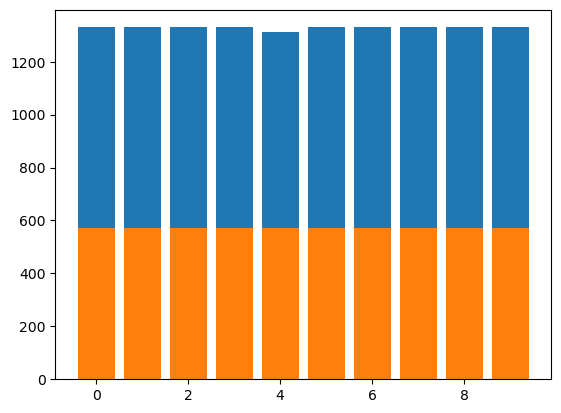

In [11]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

# Custom CNN (Melspectrogram version)

In [12]:
def conv_block(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1))(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
    x = Dropout(0.25)(x)
    return x

def conv_block_pad(x, n_filters, pool_size=(2, 2)):
    x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size, padding='same')(x)
    x = Dropout(0.25)(x)
    return x

In [13]:
#data augmentation
def random_flip_on_probability(image, probability= 0.5):
    if random.random() < probability:
      return tf.image.random_flip_left_right(image)
    return image


data_augmentation = Sequential(
  [
      tf.keras.layers.Lambda(random_flip_on_probability),
  ]
)

#CNN+LSTM model

def create_model(input_shape, num_genres):
    data_augmentation,
    inpt = Input(shape=input_shape)
    x = conv_block(inpt, 16)
    x = conv_block(x, 32)
    x = conv_block_pad(x, 64)
    x = conv_block_pad(x, 128)
    x = Conv2D(256, (3, 3), strides=(1, 1), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Reshape((16,64))(x)
    #dropout increased to 0.15
    x = LSTM(units=128, dropout=0.15, return_sequences=True, input_shape=(8,128))(x)
    x = LSTM(units=128, dropout=0.15, return_sequences=True)(x)
    x = LSTM(units=64, dropout=0.15, return_sequences=False)(x)
    
    x = Dense(units=32, kernel_regularizer=tf.keras.regularizers.l2(0.02), activation='relu')(x)
 
    predictions = Dense(num_genres, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.02))(x)

    model = Model(inputs=inpt, outputs=predictions)
    return model

In [14]:
model = create_model(X_train[0].shape, len(genres))

In [15]:
X_train[0].shape

(128, 129, 3)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 129, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 127, 16)      448       
                                                                 
 activation (Activation)     (None, 126, 127, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 64, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 64, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 62, 32)        4640      
                                                             

img_file = './model_plot.png'

tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

### Loss function

In [18]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [19]:
#reducing learning rate during accuracy plateaus through the fitting
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-5
)

In [20]:
steps_per_epoch = np.ceil(len(X_train)/128)
val_steps = np.ceil(len(X_test)/128)

hist = model.fit(X_train, y_train, batch_size=128, epochs=150,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=val_steps,
                 validation_data=(X_test, y_test), shuffle=False, 
                 callbacks=[reduceLROnPlat])

Epoch 1/150
104/104 [==============================] - 26s 92ms/step - loss: 2.9957 - accuracy: 0.1503 - val_loss: 2.5207 - val_accuracy: 0.2095 - lr: 0.0010
Epoch 2/150
104/104 [==============================] - 5s 50ms/step - loss: 2.3707 - accuracy: 0.2260 - val_loss: 2.2107 - val_accuracy: 0.2661 - lr: 0.0010
Epoch 3/150
104/104 [==============================] - 5s 44ms/step - loss: 2.1620 - accuracy: 0.2321 - val_loss: 2.0719 - val_accuracy: 0.2444 - lr: 0.0010
Epoch 4/150
104/104 [==============================] - 5s 44ms/step - loss: 2.0405 - accuracy: 0.2534 - val_loss: 1.9566 - val_accuracy: 0.2896 - lr: 0.0010
Epoch 5/150
104/104 [==============================] - 5s 45ms/step - loss: 1.9557 - accuracy: 0.2676 - val_loss: 1.9238 - val_accuracy: 0.2949 - lr: 0.0010
Epoch 6/150
104/104 [==============================] - 5s 50ms/step - loss: 1.9032 - accuracy: 0.2879 - val_loss: 1.8803 - val_accuracy: 0.3067 - lr: 0.0010
Epoch 7/150
104/104 [==============================] - 4s

Epoch 53/150
103/104 [============================>.] - ETA: 0s - loss: 1.0748 - accuracy: 0.6922
Epoch 53: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
104/104 [==============================] - 6s 53ms/step - loss: 1.0751 - accuracy: 0.6926 - val_loss: 1.3373 - val_accuracy: 0.6347 - lr: 0.0010
Epoch 54/150
104/104 [==============================] - 6s 54ms/step - loss: 1.0396 - accuracy: 0.7098 - val_loss: 1.3134 - val_accuracy: 0.6404 - lr: 9.5000e-04
Epoch 55/150
104/104 [==============================] - 6s 55ms/step - loss: 1.0282 - accuracy: 0.7173 - val_loss: 1.3178 - val_accuracy: 0.6389 - lr: 9.5000e-04
Epoch 56/150
104/104 [==============================] - 6s 54ms/step - loss: 1.0165 - accuracy: 0.7207 - val_loss: 1.3014 - val_accuracy: 0.6500 - lr: 9.5000e-04
Epoch 57/150
104/104 [==============================] - 6s 56ms/step - loss: 1.0171 - accuracy: 0.7229 - val_loss: 1.3020 - val_accuracy: 0.6511 - lr: 9.5000e-04
Epoch 58/150
104/104 [==========

Epoch 98/150
104/104 [==============================] - 5s 53ms/step - loss: 0.6912 - accuracy: 0.8670 - val_loss: 1.2340 - val_accuracy: 0.7140 - lr: 7.3509e-04
Epoch 99/150
104/104 [==============================] - ETA: 0s - loss: 0.6779 - accuracy: 0.8744
Epoch 99: ReduceLROnPlateau reducing learning rate to 0.0006983372120885178.
104/104 [==============================] - 6s 55ms/step - loss: 0.6779 - accuracy: 0.8744 - val_loss: 1.2251 - val_accuracy: 0.7181 - lr: 7.3509e-04
Epoch 100/150
104/104 [==============================] - 6s 56ms/step - loss: 0.6812 - accuracy: 0.8718 - val_loss: 1.2186 - val_accuracy: 0.7207 - lr: 6.9834e-04
Epoch 101/150
104/104 [==============================] - 5s 49ms/step - loss: 0.6761 - accuracy: 0.8713 - val_loss: 1.1964 - val_accuracy: 0.7228 - lr: 6.9834e-04
Epoch 102/150
104/104 [==============================] - 6s 54ms/step - loss: 0.6701 - accuracy: 0.8709 - val_loss: 1.1729 - val_accuracy: 0.7268 - lr: 6.9834e-04
Epoch 103/150
104/104 [==

In [21]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.185 and val_acc = 0.742


Important Note: Our initial trial results of val_acc = 0.78 got overwritten

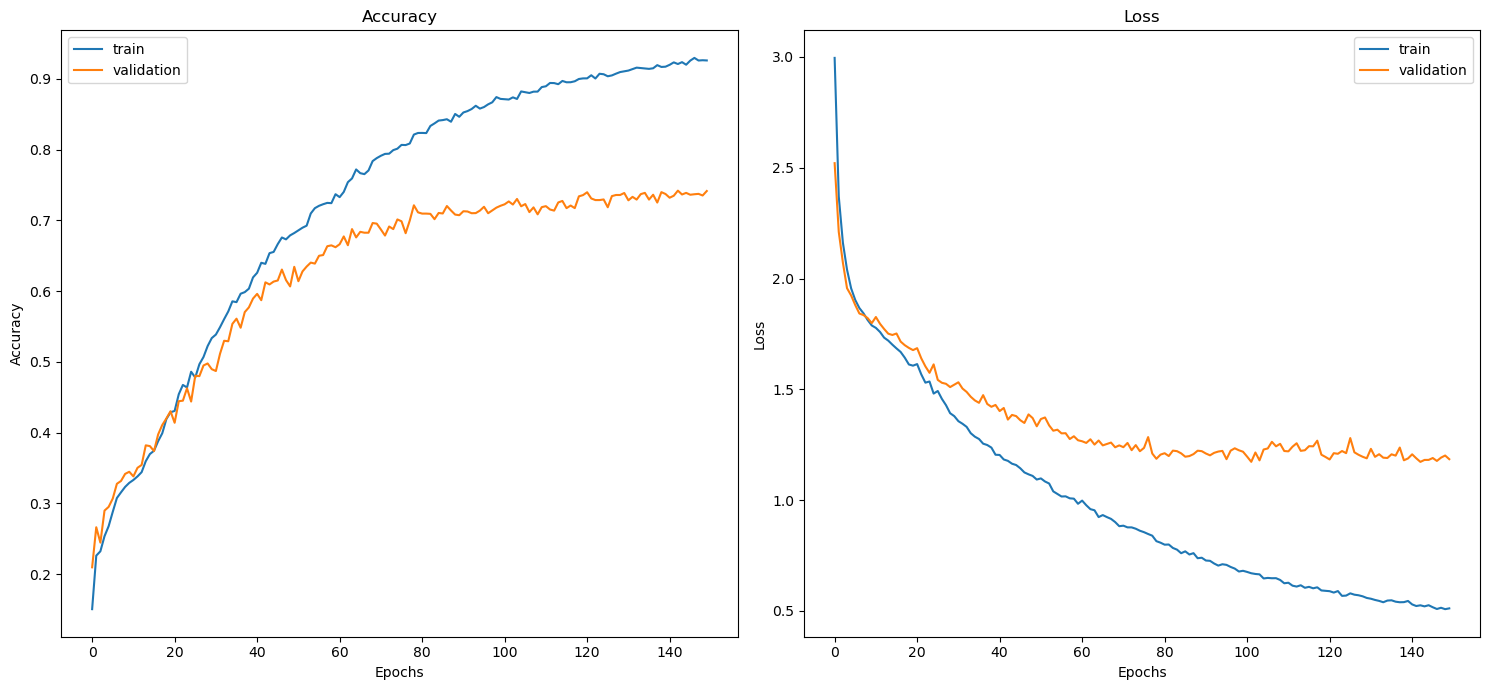

In [22]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [24]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

179/179 [==============================] - 3s 7ms/step


Normalized confusion matrix


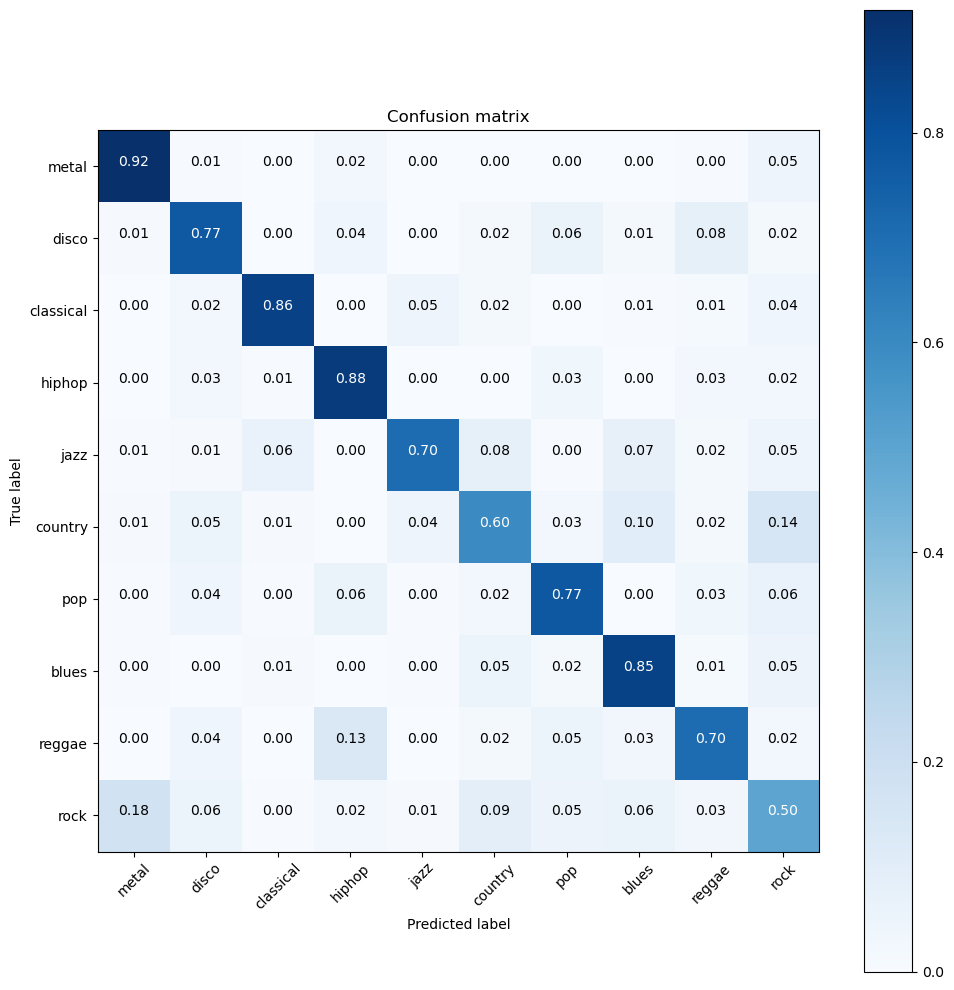

In [25]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

## Save the model

In [26]:
# Save the model
model.save('../models/custom_cnn_2d.h5')